# Importing some packages

In [1]:
import numpy as np
from numba import njit
import pandas as pd
import polars as pl
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import os
import gc

import warnings
warnings.filterwarnings('ignore')

# Limited testing

In [2]:
@njit(cache=True)
def get_signals(signal_list, exit_list):

    start_idx = 0
    exit_idx = 0
   
    for i in range(len(signal_list[0])):

        if i == start_idx:

            if signal_list[0][i] == 0:

                start_idx += 1

                exit_list[0][i] = 0

            else:

                for j in range(i+1, len(exit_list[0])):
                    if exit_list[0][j] == -signal_list[0][i]:
                        exit_idx = j
                        break
                    else:
                        exit_idx = j

                for k in range(i+1, exit_idx+1):
                    if signal_list[0][k] == -signal_list[0][i]:
                        exit_idx = k
                        exit_list[1][k] = signal_list[1][k]
                        break
                    else:
                        exit_idx = k

                for p in range(i+1, exit_idx):
                    signal_list[0][p] = 0
                    exit_list[0][p] = 0
                
                if exit_idx == len(signal_list[0]) - 1 and exit_list[0][exit_idx] != -signal_list[0][i]:
                    exit_list[0][exit_idx] = 0
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                else:
                    exit_list[0][exit_idx] = -signal_list[0][i]
                    exit_list[0][i] = 0
                    signal_list[0][exit_idx] = 0
                
                start_idx = exit_idx + 1

        else:

            continue

    if sum(np.abs(signal_list[0])) == sum(np.abs(exit_list[0])):

        return signal_list, exit_list
    
    else:

        for i in range(len(signal_list[0])):
            if signal_list[0][-(i+1)] != 0:
                signal_list[0][-(i+1)] = 0
                break

        return signal_list, exit_list
    
@njit(cache=True)
def create_position_open_prices(signal_list, exit_list):

    pos_open_prices = np.zeros(len(signal_list[0]))
    pos_exit_prices = np.zeros(len(exit_list[0]))

    start_idx = 0
    price_idx = 0

    for i in range(len(signal_list[0])):
        if exit_list[0][i] != 0:
            for j in range(start_idx, i):
                if signal_list[0][j] != 0:
                    price_idx = j
                    break
            pos_open_prices[i] = signal_list[1][price_idx]
            pos_exit_prices[i] = exit_list[1][i]
            start_idx = i
        else:
            pass

    return pos_open_prices, pos_exit_prices

@njit(cache=True)
def get_pnl_testing(
    trade_close_prices,
    signal_list, 
    trade_open_prices,
    commission=0.015,
    slippage=0.05,
    init_inv=20000,
    trade_size=0.1
):

    pnl_list = np.zeros(len(trade_close_prices))

    for i in range(len(trade_close_prices)):

        if signal_list[i] == 0 or trade_open_prices[i] == 0:
            pass
        
        # signal_list contains the points where exit occurs
        elif signal_list[i] == -1: 
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_close_prices[i] - trade_open_prices[i] * (1 + slippage)) 
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        else:
            temp_n_assets = int(init_inv * trade_size / trade_open_prices[i])
            temp_pnl = temp_n_assets * (trade_open_prices[i] * (1 - slippage) - trade_close_prices[i])
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

        pnl_list[i] = temp_pnl

    return pnl_list


## Entry testing

### Fixed stop and target exit

In [3]:
@njit(cache=True)
def get_exit_entry_testing1(
    close_prices, 
    open_prices,  
    signal_list,
    stoploss_th,
    takeprofit_th, 
    commission, 
    slippage, 
    init_inv, 
    trade_size
):

    exit_list = np.zeros((2, len(close_prices)))

    for i in range(len(close_prices)-1):

        if signal_list[1][i] == 0:

            pass

        else:

            temp_n_assets = int(init_inv * trade_size / signal_list[1][i])
            if signal_list[0][i] == 1:
                temp_pnl = temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 + slippage))
            else:
                temp_pnl = -temp_n_assets * (close_prices[i] - signal_list[1][i] * (1 - slippage))
            temp_pnl = temp_pnl * (1 - commission)
            init_inv += temp_pnl

            if -temp_pnl >= stoploss_th or temp_pnl >= takeprofit_th:
                exit_list[0][i+1] = -signal_list[0][i]
                exit_list[1][i+1] = open_prices[i+1]
            else:
                pass
        
    return exit_list


### Fixed bar exit

In [4]:
@njit(cache=True)
def get_exit_entry_testing2( 
    open_prices,  
    signal_list,
    n_exit_bars
):

    exit_list = np.zeros((2, len(signal_list[0])))

    n_exit_bars = np.int64(n_exit_bars)

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:
            
            if i + n_exit_bars < len(signal_list[0]):
                exit_list[0][i+n_exit_bars] = -signal_list[0][i]
                exit_list[1][i+n_exit_bars] = open_prices[i+n_exit_bars]
            else:
                pass
        
    return exit_list


### Random exit

In [5]:
@njit(cache=True)
def get_exit_entry_testing3( 
    open_prices,  
    signal_list
):

    exit_list = np.zeros((2, len(signal_list[0])))

    for i in range(len(signal_list[0])-1):

        if signal_list[0][i] == 0:

            pass

        else:

            for j in range(i+1, len(signal_list[0])):
                if signal_list[0][j] != 0:
                    j = j - 1
                    break
                else:
                    if np.random.rand() > 0.5:
                        break
            
            exit_list[0][j] = -signal_list[0][i]
            exit_list[1][j] = open_prices[j]
        
    return exit_list


### Winning percentage

In [6]:
def calculate_mean_win_perc_entry_testing(exec_dict, df):

    commission = exec_dict['COMMISSION']
    slippage = exec_dict['SLIPPAGE'] 
    init_inv = exec_dict['AVAILABLE_CAPITAL']
    trade_size = exec_dict['TRADE_SIZE'] 

    if len(exec_dict['buy_idxs']) != 0:
        signal_idxs = list(exec_dict['buy_idxs'])
        if len(exec_dict['sell_idxs']) != 0:
            signal_idxs.extend(list(exec_dict['sell_idxs']))
    else:
        if len(exec_dict['sell_idxs']) != 0:
            signal_idxs = list(exec_dict['sell_idxs'])
        else:
            signal_idxs = []

    if len(signal_idxs) != 0:
        signal_idxs = sorted(signal_idxs)
        signal_idxs_true = [i - 1 for i in signal_idxs]
    else:
        signal_idxs_true = []

    df['buy'] = 0
    if len(exec_dict['buy_idxs']) != 0:
        buy_idxs = [i - 1 for i in list(exec_dict['buy_idxs'])]
        df.loc[df.index.isin(buy_idxs), 'buy'] = 1

    df['sell'] = 0
    if len(exec_dict['sell_idxs']) != 0:
        sell_idxs = [i - 1 for i in list(exec_dict['sell_idxs'])]
        df.loc[df.index.isin(sell_idxs), 'sell'] = -1

    df['signal'] = df['buy'] + df['sell']

    df['new_signal'] = 0
    df['signal_prices'] = 0
    if len(signal_idxs) != 0:
        df.loc[df.index.isin(signal_idxs_true), 'new_signal'] = df.loc[df.index.isin(signal_idxs_true), 'signal'].values
        df.loc[df.index.isin(signal_idxs), 'signal_prices'] = df.loc[df.index.isin(signal_idxs), 'btc_open'].values

    signal_list = np.zeros((2, df.shape[0]))
    signal_list[0][1:] = df['new_signal'].values[:-1]
    signal_list[1] = df['signal_prices'].values

    # fixed stop and target exit testing
    exit_list = get_exit_entry_testing1(
        close_prices=df['btc_close'].values, 
        open_prices=df['btc_open'].values,  
        signal_list=signal_list,
        stoploss_th=50,
        takeprofit_th=100,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    fixed_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)

    # fixed bar exit testing
    exit_list = get_exit_entry_testing2( 
        open_prices=df['btc_open'].values,  
        signal_list=signal_list,
        n_exit_bars=5
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    fixed_bar_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)

    # random exit testing
    exit_list = get_exit_entry_testing3( 
        open_prices=df['btc_open'].values,  
        signal_list=signal_list
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    random_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)

    return fixed_winning_percent, fixed_bar_winning_percent, random_winning_percent

def get_entry_win_pc_df(entry_walk_forward_dict, n_not_worked, n_total_cases):
    
    entry_mean_win_perc_dict = defaultdict(list)

    entry_mean_win_perc_dict['Fixed_StopLoss_TakeProfit_testing'].\
        append(np.nanmean(entry_walk_forward_dict['fixed_sp_testing']))
    entry_mean_win_perc_dict['Fixed_Bar_testing'].\
        append(np.nanmean(entry_walk_forward_dict['fixed_bar_testing']))
    entry_mean_win_perc_dict['Random_Exit_testing'].\
        append(np.nanmean(entry_walk_forward_dict['random_exit_testing']))
    entry_mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
        
    entry_win_pc_df = pd.DataFrame(entry_mean_win_perc_dict)

    return entry_win_pc_df


## Exit testing

### Similar approach entry

In [7]:
@njit(cache=True)
def get_entry_exit_testing1(
    close_prices,
    open_prices,
    n_bars
):

    signal_list = np.zeros((2, len(close_prices)))

    # n_bars = np.int64(n_bars)

    for i in range(n_bars, len(signal_list[0])):
            
        if close_prices[i - n_bars] - close_prices[i - 1] > 0:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif close_prices[i - n_bars] - close_prices[i - 1] < 0:
           signal_list[0][i] = -1
           signal_list[1][i] = open_prices[i]
        else:
            pass
        
    return signal_list

@njit(cache=True)
def get_rsi(close_prices, prev_close_prices, length=14):
    # Create numpy arrays to store the gain/loss values
    gains = np.zeros(len(close_prices))
    losses = np.zeros(len(close_prices))

    # Iterate through the data frame and calculate the gain/loss for each period
    for i in range(1, len(close_prices)):
        change = close_prices[i] - prev_close_prices[i]
        if change > 0:
            gains[i] = change
        elif change < 0:
            losses[i] = abs(change)

    # Calculate the average gain and loss for each period
    avg_gains = np.zeros(len(close_prices))
    avg_losses = np.zeros(len(close_prices))
    for i in range(length, len(close_prices)):
        avg_gains[i] = np.mean(gains[i-length:i])
        avg_losses[i] = np.mean(losses[i-length:i])

    # Calculate the relative strength and RSI for each period
    rs = np.zeros(len(close_prices))
    rsi = np.zeros(len(close_prices))
    
    for i in range(len(close_prices)):
        if i+1 < length:
            rsi[i] = -999
        elif avg_losses[i] == 0:
            rs[i] = avg_gains[i]
            rsi[i] = 100
        else:
            rs[i] = avg_gains[i] / avg_losses[i]
            rsi[i] = 100 - (100 / (1 + rs[i]))

    return rsi

@njit(cache=True)
def get_entry_exit_testing2(
    close_prices, open_prices, prev_close_prices, rsi_window_size, rsi_threshold
):

    signal_list = np.zeros((2, len(close_prices)))

    rsi = get_rsi(close_prices, prev_close_prices, length=rsi_window_size)

    for i in range(len(close_prices)-1):

        if i < rsi_window_size - 1 or rsi[i] == -999:
            continue
       
        if rsi[i] < rsi_threshold:
            signal_list[0][i+1] = 1
            signal_list[1][i+1] = open_prices[i+1]
        elif rsi[i] > (100 - rsi_threshold):
            signal_list[0][i+1] = -1
            signal_list[1][i+1] = open_prices[i+1]
        else:
            pass

    return signal_list


### Random entry

In [8]:
@njit(cache=True)
def get_entry_exit_testing3(
    open_prices
):

    signal_list = np.zeros((2, len(open_prices)))

    for i in range(len(open_prices)-1):

        if np.random.rand() > 0.7:
            signal_list[0][i] = 1
            signal_list[1][i] = open_prices[i]
        elif np.random.rand() < 0.3:
            signal_list[0][i] = -1
            signal_list[1][i] = open_prices[i]
        else:
            pass

    return signal_list


### Winning percentage

In [9]:
def calculate_mean_win_perc_exit_testing(exec_dict, df):

    commission = exec_dict['COMMISSION']
    slippage = exec_dict['SLIPPAGE'] 
    init_inv = exec_dict['AVAILABLE_CAPITAL']
    trade_size = exec_dict['TRADE_SIZE']       

    if len(exec_dict['sell_exit_idxs']) != 0:
        signal_idxs = list(exec_dict['sell_exit_idxs'])
        if len(exec_dict['buy_exit_idxs']) != 0:
            signal_idxs.extend(list(exec_dict['buy_exit_idxs']))
    else:
        if len(exec_dict['buy_exit_idxs']) != 0:
            signal_idxs = list(exec_dict['buy_exit_idxs'])
        else:
            signal_idxs = []

    if len(signal_idxs) != 0:
        signal_idxs = sorted(signal_idxs)
        signal_idxs_true = [i - 1 for i in signal_idxs]
    else:
        signal_idxs_true = []

    df['buy'] = 0
    if len(exec_dict['sell_exit_idxs']) != 0:
        buy_idxs = [i - 1 for i in list(exec_dict['sell_exit_idxs'])]
        df.loc[df.index.isin(buy_idxs), 'buy'] = 1

    df['sell'] = 0
    if len(exec_dict['buy_exit_idxs']) != 0:
        sell_idxs = [i - 1 for i in list(exec_dict['buy_exit_idxs'])]
        df.loc[df.index.isin(sell_idxs), 'sell'] = -1

    df['signal'] = df['buy'] + df['sell']

    df['exit_signal'] = 0
    df['exit_prices'] = 0
    if len(signal_idxs) != 0:
        df.loc[df.index.isin(signal_idxs_true[1:]), 'exit_signal'] = df.loc[df.index.isin(signal_idxs_true[1:]), 'signal'].values
        df.loc[df.index.isin(signal_idxs[1:]), 'exit_prices'] = df.loc[df.index.isin(signal_idxs[1:]), 'btc_open'].values

    exit_list = np.zeros((2, df.shape[0]))
    exit_list[0][1:] = df['exit_signal'].values[:-1]
    exit_list[1] = df['exit_prices'].values

    # replacing entry with trend following entry
    signal_list = get_entry_exit_testing1(
        close_prices=df['btc_close'].values,
        open_prices=df['btc_open'].values,
        n_bars=5
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    trend_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)

    # replacing entry with countertrend entry
    signal_list = get_entry_exit_testing2(
        close_prices=df['btc_close'].values, 
        open_prices=df['btc_open'].values, 
        prev_close_prices=df['btc_close'].shift(1).fillna(method='bfill').values, 
        rsi_window_size=10, 
        rsi_threshold = 20
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    countertrend_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)

    # random entry testing
    signal_list = get_entry_exit_testing3(
        open_prices=df['btc_open'].values
    )

    signal_list, exit_list = get_signals(signal_list, exit_list)
    pos_open_prices, pos_exit_prices = create_position_open_prices(signal_list, exit_list)

    pnl_list = get_pnl_testing(
        trade_close_prices=pos_exit_prices,
        signal_list=exit_list[0], 
        trade_open_prices=pos_open_prices,
        commission=commission, 
        slippage=slippage, 
        init_inv=init_inv, 
        trade_size=trade_size
    )

    random_winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)


    return trend_winning_percent, countertrend_winning_percent, random_winning_percent

def get_exit_win_pc_df(exit_walk_forward_dict, n_not_worked, n_total_cases):

    exit_mean_win_perc_dict = defaultdict(list)

    exit_mean_win_perc_dict['Trend_testing'].\
        append(np.nanmean(exit_walk_forward_dict['trend_entry_testing']))
    exit_mean_win_perc_dict['Countertrend_testing'].\
        append(np.nanmean(exit_walk_forward_dict['countertrend_entry_testing']))
    exit_mean_win_perc_dict['Random_Entry_testing'].\
        append(np.nanmean(exit_walk_forward_dict['random_entry_testing']))
    exit_mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)

    exit_win_pc_df = pd.DataFrame(exit_mean_win_perc_dict)

    return exit_win_pc_df


## Core testing

### Winning percentage

In [10]:
def calculate_mean_win_perc_core_testing(exec_dict):
            
    pnl_list = exec_dict['all_arr']

    winning_percent = 100 * sum(pnl_list > 0) / np.sum(pnl_list != 0)
    
    return winning_percent

def get_core_win_pc_df(core_walk_forward_dict, n_not_worked, n_total_cases):

    core_mean_win_perc_dict = defaultdict(list)
    core_mean_win_perc_dict['Core_Testing'].\
        append(np.nanmean(core_walk_forward_dict['core_testing']))
    core_mean_win_perc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)

    core_win_pc_df = pd.DataFrame(core_mean_win_perc_dict)

    return core_win_pc_df


### Performance

In [11]:
@njit(cache=True)
def get_drawdown(pnl_list):
    max_dd = 0.0
    peak = pnl_list[0]

    for i in range(1, len(pnl_list)):
        if pnl_list[i] > peak:
            peak = pnl_list[i]
        drawdown = 100 * (peak - pnl_list[i]) / peak
        if drawdown > max_dd:
            max_dd = drawdown

    return max_dd

@njit(cache=True)
def get_drawdown_duration(pnl_arr):
    peak = pnl_arr[0]
    max_duration = 0
    current_duration = 0

    for pnl in pnl_arr:
        if pnl < peak:  # We are in a drawdown
            current_duration += 1
        else:  # We found a new peak
            peak = pnl
            current_duration = 0

        max_duration = max(max_duration, current_duration)

    return max_duration

@njit(cache=True)
def get_sharpe_ratio(
    pnl_list, 
    risk_free_rate=0
):
    # mean_return = np.mean(pnl_list)
    mean_return = 0
    for i in range(len(pnl_list)):
        mean_return += pnl_list[i]

    if len(pnl_list) == 0:
        mean_return = 0
    else:
        mean_return = mean_return / len(pnl_list)

    # std_dev = np.std(pnl_list)
    std_dev = 0
    for i in range(len(pnl_list)):
        std_dev += (pnl_list[i] - mean_return) ** 2

    if len(pnl_list) == 1:
        std_dev = np.sqrt(std_dev/len(pnl_list))
    else:
        std_dev = np.sqrt(std_dev/(len(pnl_list) - 1))

    if std_dev == 0:
        std_dev += 0.0001

    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    return sharpe_ratio

@njit(cache=True)
def get_sortino_ratio(profit_loss, target_pl=0):

    downside_pnl = profit_loss[profit_loss < target_pl]
    if len(downside_pnl) == 0:
        return 0

    downside_deviation = np.sqrt(np.mean((downside_pnl - target_pl) ** 2))
    if downside_deviation == 0:
        return 0

    mean_pnl = np.mean(profit_loss)
    sortino_ratio = (mean_pnl - target_pl) / downside_deviation

    return sortino_ratio


In [12]:
def calculate_mean_performance(exec_dict, monkey_test=False):

    pnl_list = exec_dict['all_arr']

    init_inv = exec_dict['AVAILABLE_CAPITAL']
    trade_size = exec_dict['TRADE_SIZE']       

    signal_idxs = list(exec_dict['buy_idxs'])
    signal_idxs.extend(list(exec_dict['sell_idxs']))
    signal_idxs = sorted(signal_idxs)

    metric_dict = {}

    metric_dict['n_trades'] = len(signal_idxs) - 1
    metric_dict['overall_pnl'] = np.sum(pnl_list)
    metric_dict['roi'] = 100 * metric_dict['overall_pnl'] / (trade_size * init_inv)
    metric_dict['avg_drawdown'] = exec_dict['avg_drawdown']
    metric_dict['max_dd'] = get_drawdown(pnl_list)
    metric_dict['drawdown_dur'] = get_drawdown_duration(pnl_list)
    metric_dict['pnl_avgd_ratio'] = exec_dict['fitness']

    annualized_sharpe_ration = np.sqrt(525600) * get_sharpe_ratio(pnl_list, risk_free_rate=0)
    metric_dict['sharpe_ratio'] = annualized_sharpe_ration

    annualized_sortino_ratio = np.sqrt(525600) * get_sortino_ratio(pnl_list)
    metric_dict['sortino_ratio'] = annualized_sortino_ratio

    if monkey_test:

        pnl_mren_arr = exec_dict['pnl_mren_arr']
        max_dd_mren_arr = exec_dict['max_dd_mren_arr']

        pnl_mren_good_cases = np.sum(np.where(metric_dict['overall_pnl'] > pnl_mren_arr, 1, 0))
        metric_dict['mt_pnl'] = 100 * pnl_mren_good_cases / len(pnl_mren_arr)

        max_dd_mren_good_cases = np.sum(np.where(metric_dict['max_dd'] < max_dd_mren_arr, 1, 0))
        metric_dict['mt_mdd'] = 100 * max_dd_mren_good_cases / len(max_dd_mren_arr)

    return metric_dict

def get_perf_df(performance_walk_forward_dict, n_not_worked, n_total_cases):

    mean_perf_dict = defaultdict(list)
    
    mean_perf_dict['N_Trades'].\
        append(np.nanmean(performance_walk_forward_dict['n_trades']))
    mean_perf_dict['PNL'].\
        append(np.nanmean(performance_walk_forward_dict['pnl']))
    mean_perf_dict['ROI (%)'].\
        append(np.nanmean(performance_walk_forward_dict['roi']))
    mean_perf_dict['AVG_Drawdown'].\
        append(np.nanmean(performance_walk_forward_dict['avg_drawdown']))
    mean_perf_dict['Drawdown (%)'].\
        append(np.nanmean(performance_walk_forward_dict['drawdown']))
    mean_perf_dict['Drawdown_Duration'].\
        append(np.nanmean(performance_walk_forward_dict['drawdown_dur']))
    mean_perf_dict['PNL_AVGD_Ratio'].\
        append(np.nanmean(performance_walk_forward_dict['pnl_avgd_ratio']))
    mean_perf_dict['Sharpe_Ratio'].\
        append(np.nanmean(performance_walk_forward_dict['sharpe_ratio']))
    mean_perf_dict['Sortino_Ratio'].\
        append(np.nanmean(performance_walk_forward_dict['sortino_ratio']))
    mean_perf_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)
    
    if 'mt_pnl' in performance_walk_forward_dict.keys():
        mean_perf_dict['MT_PNL_D'].\
            append(np.nanmean(performance_walk_forward_dict['mt_pnl']))
        mean_perf_dict['MT_MDD_D'].\
            append(np.nanmean(performance_walk_forward_dict['mt_mdd']))

    perf_df = pd.DataFrame(mean_perf_dict)

    return perf_df


## Equity curve Monte Carlo simulation

In [13]:
@njit(cache=True)
def get_random_idxs4mc(arr, num_elements):
    # Get the length of the input array
    n = len(arr)

    if num_elements > n:
        raise ValueError("num_elements must be less than or equal to the length of the array.")

    # Generate random indices with replacement
    indices = np.random.randint(0, n, num_elements)

    # Return sorted indices
    return indices

@njit(cache=True)
def run_simulation(pnl_list, n_runs, init_inv, trade_size):

    max_dd_array = np.zeros(n_runs)
    dd_dur_array = np.zeros(n_runs)
    profit_array = np.zeros(n_runs)
    roi_array = np.zeros(n_runs)
    binary_profit_array = np.zeros(n_runs, dtype=np.int32)
    
    for i in range(n_runs):
        
        # Generate bootstrap sample
        temp_random_idxs = get_random_idxs4mc(arr=pnl_list, num_elements=len(pnl_list))
        temp_pnl_list = np.zeros(len(temp_random_idxs))
        for j in range(len(temp_random_idxs)):
            temp_pnl_list[j] = pnl_list[temp_random_idxs[j]]

        equity_curve_list = np.cumsum(temp_pnl_list)
        
        # Max Drawdown
        max_dd = get_drawdown(equity_curve_list)
        max_dd_array[i] = max_dd
        
        # Drawdown Duration
        dd_dur = get_drawdown_duration(equity_curve_list)
        dd_dur_array[i] = dd_dur
        
        # Profit
        profit = np.sum(temp_pnl_list)
        profit_array[i] = profit
        
        # ROI
        roi = 100 * profit / (init_inv * trade_size)
        roi_array[i] = roi
        
        # Binary Profit
        if profit > 0:
            binary_profit_array[i] = 1

    return max_dd_array, dd_dur_array, profit_array, roi_array, binary_profit_array


In [14]:
def get_mc_results(pnl_list, init_inv, trade_size, n_runs):

    max_dd_array, dd_dur_array, profit_array, roi_array, binary_profit_array = run_simulation(pnl_list, n_runs, init_inv, trade_size)

    mc_dict = {}
    mc_dict['median_max_dd'] = np.median(max_dd_array)
    mc_dict['median_dd_dur'] = np.median(dd_dur_array)
    mc_dict['median_profit'] = np.median(profit_array)
    mc_dict['median_return'] = np.median(roi_array)
    mc_dict['return_dd_ratio'] = np.median(roi_array) / np.median(max_dd_array)
    mc_dict['prob_profit'] = np.sum(binary_profit_array) / len(binary_profit_array)

    return mc_dict


In [15]:
def calculate_mc_performance(exec_dict):
            
    pnl_list = exec_dict['all_arr']

    init_inv = exec_dict['AVAILABLE_CAPITAL']
    trade_size = exec_dict['TRADE_SIZE']       

    mc_dict = get_mc_results(pnl_list, init_inv, trade_size, n_runs=10000)

    return mc_dict

def get_mc_df(mc_walk_forward_dict, n_not_worked, n_total_cases):

    mean_mc_dict = defaultdict(list)

    mean_mc_dict['median_drawdown (%)'].\
        append(np.nanmean(mc_walk_forward_dict['median_max_dd']))
    mean_mc_dict['median_drawdown_duration'].\
        append(np.nanmean(mc_walk_forward_dict['median_dd_dur']))
    mean_mc_dict['median_profit'].\
        append(np.nanmean(mc_walk_forward_dict['median_profit']))
    mean_mc_dict['median_ROI (%)'].\
        append(np.nanmean(mc_walk_forward_dict['median_return']))
    mean_mc_dict['ratio'].\
        append(np.nanmean(mc_walk_forward_dict['return_dd_ratio']))
    mean_mc_dict['prob'].\
        append(np.nanmean(mc_walk_forward_dict['prob_profit']))
    mean_mc_dict['Not_Working'].\
        append(100 * n_not_worked / n_total_cases)

    mc_df = pd.DataFrame(mean_mc_dict)

    return mc_df


# Data loading function

In [16]:
def generate_fold_data(data_path, fold=1):
    
    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.iloc[50400*fold:(fold+1)*50400]
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df

In [17]:
def generate_test_data(data_path):
    
    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.sort_values('datetime', ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)

    return df

# Testing strategies constructed from combination with other instruments

## Loading price and volume data

In [18]:
data_path = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min_all.csv')
df_data = generate_fold_data(data_path, fold=1)

# df_data = generate_test_data(data_path)

df_data.head()

,datetime,btc_open,btc_high,btc_low,btc_close,btc_volume,6e_open,6e_high,6e_low,6e_close,...,zf_open,zf_high,zf_low,zf_close,zf_volume,zn_open,zn_high,zn_low,zn_close,zn_volume
0,2023-12-06 18:14:00,43912.92,43915.70,43879.77,43882.77,8.708274,1.07875,1.07875,1.07870,1.07870,...,107.578125,107.578125,107.578125,107.578125,185.0,111.171875,111.171875,111.171875,111.171875,1018.0
1,2023-12-06 18:15:00,43882.77,43893.45,43877.81,43884.64,7.189239,1.07875,1.07875,1.07870,1.07870,...,107.585938,107.585938,107.578125,107.585938,936.0,111.171875,111.187500,111.156250,111.156250,3129.0
2,2023-12-06 18:16:00,43884.14,43885.91,43853.00,43866.66,13.197252,1.07865,1.07865,1.07855,1.07855,...,107.578125,107.578125,107.578125,107.578125,67.0,111.171875,111.171875,111.156250,111.171875,676.0
3,2023-12-06 18:17:00,43866.65,43895.93,43866.13,43886.67,10.187514,1.07850,1.07850,1.07830,1.07830,...,107.578125,107.578125,107.570312,107.570312,400.0,111.171875,111.171875,111.156250,111.171875,439.0
4,2023-12-06 18:18:00,43886.67,43953.98,43884.99,43926.32,11.212703,1.07830,1.07835,1.07815,1.07820,...,107.570312,107.570312,107.562500,107.562500,1098.0,111.156250,111.171875,111.140625,111.140625,2064.0


## Loading strategies generated

In [19]:
strategy_file_path = Path(r"C:/\Users/\vchar/\Downloads/\ge_results (5).csv")

try:
    df_str = pd.read_csv(strategy_file_path)
except:
    df_str = pd.read_csv(strategy_file_path, sep=';')
    
df_str = df_str[df_str['fitness'] < 0]
df_str = df_str[~df_str.duplicated()]

df_str_get1000 = df_str[df_str['fitness'] <= -1000]#.reset_index(drop=True).iloc[:1000]
df_str_lt1000 = df_str[df_str['fitness'] > -1000].reset_index(drop=True).iloc[:1000]
# df_str_small_fitness = df_str[(df_str['fitness'] > -100) & (df_str['fitness'] < -50)]

df_str = pd.concat([df_str_get1000, df_str_lt1000], axis=0)
# df_str = pd.concat([df_str, df_str_small_fitness], axis=0)

df_str.sort_values('fitness', ascending=True, inplace=True)
df_str.reset_index(drop=True, inplace=True)
df_str['strategy'] = [f'strategy{i+1}' for i in range(df_str.shape[0])]
df_str

,buy,exit_buy,sell,exit_sell,fitness,strategy
0,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-2.147956e+06,strategy1
1,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-2.057532e+06,strategy2
2,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-2.057532e+06,strategy3
3,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-2.057532e+06,strategy4
4,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-2.046611e+06,strategy5
...,...,...,...,...,...,...
6452,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['day_of_week'][MAX_LAG:] != 2),(price_data['btc_close'][MAX_LAG:] < get_lag(p...,(price_data['day_of_week'][MAX_LAG:] != 2),-2.407510e-02,strategy6453
6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['day_of_week'][MAX_LAG:] != 7),"((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",(price_data['day_of_week'][MAX_LAG:] != 7),-1.541803e-02,strategy6454
6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['day_of_week'][MAX_LAG:] <= 6),"((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",(price_data['day_of_week'][MAX_LAG:] <= 6),-1.541803e-02,strategy6455
6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['day_of_week'][MAX_LAG:] >= 5),"((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",(price_data['day_of_week'][MAX_LAG:] >= 5),-2.700245e-04,strategy6456


## Running the tests over the strategies

In [ ]:
final_entry_win_pc_df = pd.DataFrame()
final_exit_win_pc_df = pd.DataFrame()
final_core_win_pc_df = pd.DataFrame()
final_perf_df = pd.DataFrame()
final_mc_df = pd.DataFrame()

equity_curve_dict = {}

bars_per_5week = 7 * 60 * 24 * 5
n_bars_per_year = 7 * 60 * 24 * 52

if df_data.shape[0] < n_bars_per_year:
    n_bars_per_year = df_data.shape[0]

lag_txt = '{i}'

strategy_idx = 1

equity_curve_dict = defaultdict(list)

for row in tqdm(df_str.itertuples()):#df_str.iloc[:10].itertuples()

    buy_signal_txt = row.buy
    buy_exit_txt = row.exit_buy
    sell_signal_txt = row.sell
    sell_exit_txt = row.exit_sell

    text_code = f'''import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators, signals
from fitness.performance.helper_func import merge_buy_sell_pnl, get_drawdowns, get_pnl, get_lag
from fitness.performance.helper_func import trading_signals_buy, trading_signals_sell, change_exit
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 99
buy_idxs, buy_exit_idxs = trading_signals_buy(buy_signal={buy_signal_txt}, exit_signal={buy_exit_txt})
sell_idxs, sell_exit_idxs = trading_signals_sell(sell_signal={sell_signal_txt}, exit_signal={sell_exit_txt})
# if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
#     fitness = -9999999
#     avg_drawdown = -9999999
# else:
try:
    buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs = change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs)
except:
    pass
if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
    fitness = -9999999
    avg_drawdown = -9999999
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    # pnl_mren_arr, max_dd_mren_arr = get_monkey_test_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    buy_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_exit_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
    sell_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_exit_idxs)]
    buy_arr = get_pnl(buy_exit_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(sell_exit_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr)
    total_pnl = buy_pnl + sell_pnl
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    if len(drawdowns[drawdowns!=0]) != 0:
        avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
        fitness = total_pnl / avg_drawdown
    elif total_pnl <= 0 or len(drawdowns[drawdowns!=0]) == 0:
        fitness = -9999999
        avg_drawdown = -9999999
gc.collect()'''
    
    entry_test_n_not_worked = 0
    exit_test_n_not_worked = 0
    core_test_n_not_worked = 0
    perf_n_not_worked = 0
    mc_n_not_worked = 0
    n_total_cases = 0

    entry_walk_forward_dict = defaultdict(list)

    exit_walk_forward_dict = defaultdict(list)

    core_walk_forward_dict = defaultdict(list)

    performance_walk_forward_dict = defaultdict(list)

    mc_walk_forward_dict = defaultdict(list)

    for idx in range(0, n_bars_per_year, bars_per_5week):

        n_total_cases += 1

        # df = df_data.iloc[idx:idx+bars_per_5week, :]
        # df.reset_index(drop=True, inplace=True)
        df = df_data.iloc[idx:idx+bars_per_5week, :]
        df.reset_index(drop=True, inplace=True)

        price_data = {}
        for col in df.columns:
            if col == 'datetime':
                continue
            else:
                price_data[col] = df[col].values
        price_data['day_of_week'] = (df['datetime'].dt.dayofweek + 1).values
        price_data['month'] = df['datetime'].dt.month.values
        price_data['hour'] = df['datetime'].dt.hour.values
        price_data['minute'] = df['datetime'].dt.minute.values

        exec_dict = {'price_data': price_data}
        exec(text_code, exec_dict)

        try:
            equity_curve_arr = exec_dict['equity_curve_arr']
            equity_curve_dict[strategy_idx].append(equity_curve_arr)
        except:
            pass

        try:
            fixed_winning_percent, fixed_bar_winning_percent, random_winning_percent = calculate_mean_win_perc_entry_testing(exec_dict, df)
            entry_walk_forward_dict['fixed_sp_testing'].append(fixed_winning_percent)
            entry_walk_forward_dict['fixed_bar_testing'].append(fixed_bar_winning_percent)
            entry_walk_forward_dict['random_exit_testing'].append(random_winning_percent)
        except:
            entry_test_n_not_worked += 1

        try:
            trend_winning_percent, countertrend_winning_percent, random_winning_percent = calculate_mean_win_perc_exit_testing(exec_dict, df)
            exit_walk_forward_dict['trend_entry_testing'].append(trend_winning_percent)
            exit_walk_forward_dict['countertrend_entry_testing'].append(countertrend_winning_percent)
            exit_walk_forward_dict['random_entry_testing'].append(random_winning_percent)
        except:
            exit_test_n_not_worked += 1

        try:
            winning_percent = calculate_mean_win_perc_core_testing(exec_dict)
            core_walk_forward_dict['core_testing'].append(winning_percent)
        except:
            core_test_n_not_worked += 1

        try:
            metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
            performance_walk_forward_dict['n_trades'].append(metric_dict['n_trades'])
            performance_walk_forward_dict['pnl'].append(metric_dict['overall_pnl'])
            performance_walk_forward_dict['roi'].append(metric_dict['roi'])
            performance_walk_forward_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
            performance_walk_forward_dict['drawdown'].append(metric_dict['max_dd'])
            performance_walk_forward_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
            performance_walk_forward_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
            performance_walk_forward_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
            performance_walk_forward_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
            if 'mt_pnl' in metric_dict.keys():
                performance_walk_forward_dict['mt_pnl'].append(metric_dict['mt_pnl'])
                performance_walk_forward_dict['mt_mdd'].append(metric_dict['mt_mdd'])
        except:
            perf_n_not_worked += 1

        try:
            mc_dict = calculate_mc_performance(exec_dict)
            mc_walk_forward_dict['median_max_dd'].append(mc_dict['median_max_dd'])
            mc_walk_forward_dict['median_dd_dur'].append(mc_dict['median_dd_dur'])
            mc_walk_forward_dict['median_profit'].append(mc_dict['median_profit'])
            mc_walk_forward_dict['median_return'].append(mc_dict['median_return'])
            mc_walk_forward_dict['return_dd_ratio'].append(mc_dict['return_dd_ratio'])
            mc_walk_forward_dict['prob_profit'].append(mc_dict['prob_profit'])
        except:
            mc_n_not_worked += 1

    temp_signal_df = pd.DataFrame({'strategy': f'strategy{strategy_idx}', 'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})

    entry_win_pc_df = get_entry_win_pc_df(entry_walk_forward_dict, entry_test_n_not_worked, n_total_cases)
    entry_win_pc_df = pd.concat([temp_signal_df, entry_win_pc_df], axis=1)
    final_entry_win_pc_df = pd.concat([final_entry_win_pc_df, entry_win_pc_df])

    exit_win_pc_df = get_exit_win_pc_df(exit_walk_forward_dict, exit_test_n_not_worked, n_total_cases)
    exit_win_pc_df = pd.concat([temp_signal_df, exit_win_pc_df], axis=1)
    final_exit_win_pc_df = pd.concat([final_exit_win_pc_df, exit_win_pc_df])

    core_win_pc_df = get_core_win_pc_df(core_walk_forward_dict, core_test_n_not_worked, n_total_cases)
    core_win_pc_df = pd.concat([temp_signal_df, core_win_pc_df], axis=1)
    final_core_win_pc_df = pd.concat([final_core_win_pc_df, core_win_pc_df])

    perf_df = get_perf_df(performance_walk_forward_dict, perf_n_not_worked, n_total_cases)
    perf_df = pd.concat([temp_signal_df, perf_df], axis=1)
    final_perf_df = pd.concat([final_perf_df, perf_df])

    mc_df = get_mc_df(mc_walk_forward_dict, mc_n_not_worked, n_total_cases)
    mc_df = pd.concat([temp_signal_df, mc_df], axis=1)
    final_mc_df = pd.concat([final_mc_df, mc_df])

    gc.collect()

    strategy_idx += 1

6457it [1:26:51,  1.24it/s]


In [21]:
final_entry_win_pc_df.reset_index(drop=True, inplace=True)
final_exit_win_pc_df.reset_index(drop=True, inplace=True)
final_core_win_pc_df.reset_index(drop=True, inplace=True) 
final_perf_df.reset_index(drop=True, inplace=True)
final_mc_df.reset_index(drop=True, inplace=True)

# If kernel dies uncomment the code and specify the paths to load the dataframes

In [20]:
final_entry_win_pc_df = pd.read_csv('testing_results/entry_testing_fold1_p2_crossover8.csv')
final_exit_win_pc_df = pd.read_csv('testing_results/exit_testing_fold1_p2_crossover8.csv')
final_core_win_pc_df = pd.read_csv('testing_results/core_testing_fold1_p2_crossover8.csv')
final_perf_df = pd.read_csv('testing_results/perf_fold1_p2_crossover8.csv')
final_mc_df = pd.read_csv('testing_results/mc_fold1_p2_crossover8.csv')

## Showing the entry testing results

In [21]:
final_entry_win_pc_df

,strategy,buy,sell,Fixed_StopLoss_TakeProfit_testing,Fixed_Bar_testing,Random_Exit_testing,Not_Working
0,strategy1,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,40.763191,49.306318,55.742240,0.0
1,strategy2,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,35.071803,48.578054,57.753097,0.0
2,strategy3,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,35.098247,48.578054,51.917170,0.0
3,strategy4,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,35.071803,48.578054,54.553777,0.0
4,strategy5,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,30.084211,55.677611,63.500814,0.0
...,...,...,...,...,...,...,...
6452,strategy6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,53.202487,75.975039,29.901516,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",55.538044,77.290393,55.359794,0.0
6454,strategy6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",55.538044,77.290393,77.292376,0.0
6455,strategy6456,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",40.369142,68.713863,40.613948,0.0


### Finding strategies that have winning percentage equal to 50 or more for entry testing cases

In [22]:
entry_testing_strategies = final_entry_win_pc_df[
    (final_entry_win_pc_df['Fixed_StopLoss_TakeProfit_testing'] >= 50) & 
    (final_entry_win_pc_df['Fixed_Bar_testing'] >= 50) & 
    (final_entry_win_pc_df['Random_Exit_testing'] >= 50)
]['strategy'].tolist()
final_entry_win_pc_df[final_entry_win_pc_df['strategy'].isin(entry_testing_strategies)]

,strategy,buy,sell,Fixed_StopLoss_TakeProfit_testing,Fixed_Bar_testing,Random_Exit_testing,Not_Working
15,strategy16,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,50.262398,51.226657,72.887596,0.0
30,strategy31,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,56.977572,50.458566,58.532271,0.0
51,strategy52,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,55.399729,55.061206,50.569337,0.0
52,strategy53,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,55.399729,55.061206,54.608487,0.0
53,strategy54,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,55.399729,55.061206,57.142857,0.0
...,...,...,...,...,...,...,...
6423,strategy6424,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",55.538044,77.290393,55.359794,0.0
6426,strategy6427,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",57.082448,78.623610,57.568764,0.0
6445,strategy6446,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",76.657893,76.499639,53.841316,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",55.538044,77.290393,55.359794,0.0


## Showing exit testing results

In [23]:
final_exit_win_pc_df

,strategy,buy,sell,Trend_testing,Countertrend_testing,Random_Entry_testing,Not_Working
0,strategy1,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.737394,60.927481,47.607423,0.0
1,strategy2,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.729456,60.927481,47.278608,0.0
2,strategy3,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.709611,60.927481,47.631522,0.0
3,strategy4,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.729456,60.927481,47.419489,0.0
4,strategy5,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.729456,60.927481,48.139623,0.0
...,...,...,...,...,...,...,...
6452,strategy6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,62.763192,60.927481,47.455206,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,46.741676,0.0
6454,strategy6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,47.342104,0.0
6455,strategy6456,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.765176,60.846088,48.440105,0.0


### Showing strategies that have passed entry testing

In [24]:
final_exit_win_pc_df[final_exit_win_pc_df['strategy'].isin(entry_testing_strategies)]

,strategy,buy,sell,Trend_testing,Countertrend_testing,Random_Entry_testing,Not_Working
15,strategy16,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.725487,60.927481,48.190261,0.0
30,strategy31,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.711595,60.927481,47.057306,0.0
51,strategy52,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.705642,60.812340,46.751752,0.0
52,strategy53,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.697704,60.812340,47.200063,0.0
53,strategy54,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.705642,60.812340,47.257719,0.0
...,...,...,...,...,...,...,...
6423,strategy6424,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,46.324230,0.0
6426,strategy6427,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.792959,60.927481,48.127716,0.0
6445,strategy6446,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.769145,60.927481,48.303437,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,46.741676,0.0


### Showing strategies that have winning percentage equal to 50 or more (except for Random_Entry_testing)

In [25]:
exit_testing_strategies = final_exit_win_pc_df[
    (final_exit_win_pc_df['Trend_testing'] >= 50) & 
    (final_exit_win_pc_df['Countertrend_testing'] >= 50) & 
    # (final_exit_win_pc_df['Random_Entry_testing'] >= 50) &
    (final_exit_win_pc_df['strategy'].isin(entry_testing_strategies))
]['strategy'].tolist()

final_exit_win_pc_df[final_exit_win_pc_df['strategy'].isin(exit_testing_strategies)]

,strategy,buy,sell,Trend_testing,Countertrend_testing,Random_Entry_testing,Not_Working
15,strategy16,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.725487,60.927481,48.190261,0.0
30,strategy31,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.711595,60.927481,47.057306,0.0
51,strategy52,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.705642,60.812340,46.751752,0.0
52,strategy53,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.697704,60.812340,47.200063,0.0
53,strategy54,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,62.705642,60.812340,47.257719,0.0
...,...,...,...,...,...,...,...
6423,strategy6424,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,46.324230,0.0
6426,strategy6427,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.792959,60.927481,48.127716,0.0
6445,strategy6446,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.769145,60.927481,48.303437,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",62.737394,60.927481,46.741676,0.0


## Showing core testing results

In [26]:
final_core_win_pc_df

,strategy,buy,sell,Core_Testing,Not_Working
0,strategy1,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,40.000000,0.0
1,strategy2,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,45.238095,0.0
2,strategy3,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,45.238095,0.0
3,strategy4,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,45.238095,0.0
4,strategy5,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,42.857143,0.0
...,...,...,...,...,...
6452,strategy6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,40.000000,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",30.000000,0.0
6454,strategy6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",30.000000,0.0
6455,strategy6456,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",30.000000,0.0


### Showing strategies that has passed entry testing and have winning percentage equal to 60 or more

In [27]:
core_testing_strategies = final_core_win_pc_df[
    (final_core_win_pc_df['Core_Testing'] >= 60) &
    (final_core_win_pc_df['strategy'].isin(entry_testing_strategies))
]['strategy'].tolist()

final_core_win_pc_df[final_core_win_pc_df['strategy'].isin(core_testing_strategies)]

,strategy,buy,sell,Core_Testing,Not_Working
803,strategy804,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.346535,0.0
807,strategy808,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.686275,0.0
812,strategy813,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,63.725490,0.0
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,61.875000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.822785,0.0
...,...,...,...,...,...
6362,strategy6363,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6397,strategy6398,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6398,strategy6399,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6410,strategy6411,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,60.000000,0.0


### Showing strategies that has passed both entry and exit testing and have winning percentage equal to 60 or more

In [28]:
core_testing_strategies2 = final_core_win_pc_df[
    (final_core_win_pc_df['Core_Testing'] >= 60) &
    (final_core_win_pc_df['strategy'].isin(exit_testing_strategies))
]['strategy'].tolist()

final_core_win_pc_df[final_core_win_pc_df['strategy'].isin(core_testing_strategies2)]

,strategy,buy,sell,Core_Testing,Not_Working
803,strategy804,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.346535,0.0
807,strategy808,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.686275,0.0
812,strategy813,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,63.725490,0.0
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,61.875000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,65.822785,0.0
...,...,...,...,...,...
6362,strategy6363,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6397,strategy6398,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6398,strategy6399,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,70.000000,0.0
6410,strategy6411,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,60.000000,0.0


## Showing performance

In [29]:
final_perf_df

,strategy,buy,sell,N_Trades,PNL,ROI (%),AVG_Drawdown,Drawdown (%),Drawdown_Duration,PNL_AVGD_Ratio,Sharpe_Ratio,Sortino_Ratio,Not_Working
0,strategy1,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,39.0,-59693.099337,-17.055171,9418.369233,581.981561,22.0,-6.337944,-151.036447,-144.538924,0.0
1,strategy2,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,41.0,-53082.486169,-15.166425,7996.410557,1931.517629,22.0,-6.638289,-131.444899,-121.517766,0.0
2,strategy3,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,41.0,-52527.405093,-15.007830,7968.657197,1526.368642,22.0,-6.591751,-130.076550,-120.348523,0.0
3,strategy4,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,41.0,-53082.486169,-15.166425,7996.410557,1931.517629,22.0,-6.638289,-131.444899,-121.517766,0.0
4,strategy5,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,41.0,-54459.979041,-15.559994,7445.631961,1931.517629,22.0,-7.314353,-134.812165,-127.184521,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,strategy6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,-9154.651553,-2.615615,9229.676846,6861.378518,3.0,-0.991871,-118.880394,-136.329851,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",9.0,-6120.991245,-1.748855,7119.447263,127.254924,3.0,-0.859757,-226.733707,-204.980532,0.0
6454,strategy6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",9.0,-6120.991245,-1.748855,7119.447263,127.254924,3.0,-0.859757,-226.733707,-204.980532,0.0
6455,strategy6456,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",9.0,-51772.229894,-14.792066,4418.339829,4943.119000,5.0,-11.717575,-478.690809,-346.568184,0.0


### Showing performance for strategies that has passed entry and core testing and have positive ROI

In [30]:
perf_strategies = final_perf_df[
    (final_perf_df['strategy'].isin(core_testing_strategies)) & 
    (final_perf_df['ROI (%)'] > 0)
]['strategy'].tolist()

final_perf_df[final_perf_df['strategy'].isin(perf_strategies)]

,strategy,buy,sell,N_Trades,PNL,ROI (%),AVG_Drawdown,Drawdown (%),Drawdown_Duration,PNL_AVGD_Ratio,Sharpe_Ratio,Sortino_Ratio,Not_Working
803,strategy804,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,100.0,89321.362909,25.520389,4015.029523,295.400482,80.0,22.246751,122.616532,107.902119,0.0
807,strategy808,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,101.0,92695.317106,26.484376,3854.428342,295.400482,81.0,24.049044,126.487176,110.880105,0.0
812,strategy813,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,101.0,84358.439764,24.102411,3589.115873,291.480313,81.0,23.503961,119.171164,104.179236,0.0
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,159.0,195087.286806,55.739225,1056.710693,381.639059,86.0,184.617500,202.318032,690.988000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,78.0,186327.984575,53.236567,1803.900288,295.400482,35.0,103.291732,284.188485,941.615159,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356,strategy6357,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0
6357,strategy6358,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0
6362,strategy6363,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,10763.666838,3.075333,9991.330314,1480.754768,4.0,1.077301,72.986228,62.924416,0.0
6397,strategy6398,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0


### Showing performance for strategies that has passed all tests and have positive ROI

In [31]:
perf_strategies2 = final_perf_df[
    (final_perf_df['strategy'].isin(core_testing_strategies2)) & 
    (final_perf_df['ROI (%)'] > 0)
]['strategy'].tolist()

final_perf_df[final_perf_df['strategy'].isin(perf_strategies2)]

,strategy,buy,sell,N_Trades,PNL,ROI (%),AVG_Drawdown,Drawdown (%),Drawdown_Duration,PNL_AVGD_Ratio,Sharpe_Ratio,Sortino_Ratio,Not_Working
803,strategy804,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,100.0,89321.362909,25.520389,4015.029523,295.400482,80.0,22.246751,122.616532,107.902119,0.0
807,strategy808,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,101.0,92695.317106,26.484376,3854.428342,295.400482,81.0,24.049044,126.487176,110.880105,0.0
812,strategy813,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,101.0,84358.439764,24.102411,3589.115873,291.480313,81.0,23.503961,119.171164,104.179236,0.0
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,159.0,195087.286806,55.739225,1056.710693,381.639059,86.0,184.617500,202.318032,690.988000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,78.0,186327.984575,53.236567,1803.900288,295.400482,35.0,103.291732,284.188485,941.615159,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356,strategy6357,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0
6357,strategy6358,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0
6362,strategy6363,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,10763.666838,3.075333,9991.330314,1480.754768,4.0,1.077301,72.986228,62.924416,0.0
6397,strategy6398,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,9.0,2980.232023,0.851495,5865.856410,291.782793,6.0,0.508064,40.730920,34.450534,0.0


### Showing Monte Carlo simulation

In [32]:
final_mc_df

,strategy,buy,sell,median_drawdown (%),median_drawdown_duration,median_profit,median_ROI (%),ratio,prob,Not_Working
0,strategy1,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,455.279196,36.0,-60828.536077,-17.379582,-0.038173,0.0926,0.0
1,strategy2,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,569.329852,37.0,-53833.111775,-15.380889,-0.027016,0.1156,0.0
2,strategy3,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,600.381758,37.0,-53000.366278,-15.142962,-0.025222,0.1173,0.0
3,strategy4,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,574.253160,37.0,-53954.758154,-15.415645,-0.026845,0.1127,0.0
4,strategy5,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,522.055956,37.0,-54681.526999,-15.623293,-0.029926,0.1141,0.0
...,...,...,...,...,...,...,...,...,...,...
6452,strategy6453,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",(price_data['btc_close'][MAX_LAG:] < get_lag(p...,103.713344,7.0,-10464.689225,-2.989911,-0.028829,0.2799,0.0
6453,strategy6454,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",75.554587,8.0,-5749.045072,-1.642584,-0.021740,0.1449,0.0
6454,strategy6455,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",63.788935,8.0,-5656.024004,-1.616007,-0.025334,0.1478,0.0
6455,strategy6456,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...","((get_lag(price_data['btc_low'], lag=3)[MAX_LA...",0.000000,9.0,-50047.897948,-14.299399,-inf,0.0007,0.0


### Showing simulation results for strategies that has passed entry and core testing and have positive ROI

In [33]:
# mc_strategies_list = final_perf_df[
#     (final_perf_df['strategy'].isin(core_testing_strategies)) & 
#     (final_perf_df['ROI (%)'] > 0)
# ]['strategy']

mc_strategies = final_mc_df[
    (final_mc_df['strategy'].isin(perf_strategies)) &
    (final_mc_df['prob'] > 0.98) & 
    (final_mc_df['ratio'] > 1)
]['strategy'].values

final_mc_df[final_mc_df['strategy'].isin(mc_strategies)]

,strategy,buy,sell,median_drawdown (%),median_drawdown_duration,median_profit,median_ROI (%),ratio,prob,Not_Working
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,44.410307,18.0,191675.147711,54.764328,1.233145,1.0000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,29.092898,9.0,183648.976620,52.471136,1.803572,1.0000,0.0
915,strategy916,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,25.093735,6.0,181062.982279,51.732281,2.061562,1.0000,0.0
916,strategy917,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,19.254219,9.0,194336.731188,55.524780,2.883772,1.0000,0.0
918,strategy919,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,19.528341,9.0,193995.378902,55.427251,2.838298,1.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
5304,strategy5305,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,16.410201,6.0,166368.937207,47.533982,2.896612,1.0000,0.0
5336,strategy5337,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,17.379353,9.0,210849.928176,60.242837,3.466345,1.0000,0.0
5344,strategy5345,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",((numba_indicators.moving_average(prices=price...,20.471002,10.0,206437.883587,58.982252,2.881259,1.0000,0.0
5362,strategy5363,((numba_indicators.moving_average(prices=price...,(numba_indicators.adx(high=price_data['btc_hig...,2.236743,1.0,133827.263982,38.236361,17.094659,1.0000,0.0


### Showing simulation results for strategies that has passed all tests and have positive ROI

In [34]:
# mc_strategies_list2 = final_perf_df[
#     (final_perf_df['strategy'].isin(core_testing_strategies2)) & 
#     (final_perf_df['ROI (%)'] > 0)
# ]['strategy']

# final_mc_df[final_mc_df['strategy'].isin(mc_strategies_list2)]

mc_strategies2 = final_mc_df[
    (final_mc_df['strategy'].isin(perf_strategies2)) &
    (final_mc_df['prob'] > 0.98) &
    (final_mc_df['ratio'] > 1)
]['strategy'].values

final_mc_df[final_mc_df['strategy'].isin(mc_strategies2)]

,strategy,buy,sell,median_drawdown (%),median_drawdown_duration,median_profit,median_ROI (%),ratio,prob,Not_Working
814,strategy815,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,44.410307,18.0,191675.147711,54.764328,1.233145,1.0000,0.0
820,strategy821,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,29.092898,9.0,183648.976620,52.471136,1.803572,1.0000,0.0
915,strategy916,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,25.093735,6.0,181062.982279,51.732281,2.061562,1.0000,0.0
916,strategy917,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,19.254219,9.0,194336.731188,55.524780,2.883772,1.0000,0.0
918,strategy919,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,19.528341,9.0,193995.378902,55.427251,2.838298,1.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
5304,strategy5305,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,16.410201,6.0,166368.937207,47.533982,2.896612,1.0000,0.0
5336,strategy5337,((numba_indicators.moving_average(prices=price...,((numba_indicators.moving_average(prices=price...,17.379353,9.0,210849.928176,60.242837,3.466345,1.0000,0.0
5344,strategy5345,"((get_lag(price_data['btc_high'], lag=3)[MAX_L...",((numba_indicators.moving_average(prices=price...,20.471002,10.0,206437.883587,58.982252,2.881259,1.0000,0.0
5362,strategy5363,((numba_indicators.moving_average(prices=price...,(numba_indicators.adx(high=price_data['btc_hig...,2.236743,1.0,133827.263982,38.236361,17.094659,1.0000,0.0


# Saving the dataframes derived above

In [35]:
# final_entry_win_pc_df = pd.read_csv('testing_results/entry_testing_fold1_p2_crossover8.csv')
# final_exit_win_pc_df = pd.read_csv('testing_results/exit_testing_fold1_p2_crossover8.csv')
# final_core_win_pc_df = pd.read_csv('testing_results/core_testing_fold1_p2_crossover8.csv')
# final_perf_df = pd.read_csv('testing_results/perf_fold1_p2_crossover8.csv')
# final_mc_df = pd.read_csv('testing_results/mc_fold1_p2_crossover8.csv')

In [36]:
# if not os.path.exists('testing_results'):
#     os.mkdir('testing_results')

# final_entry_win_pc_df.to_csv('testing_results/entry_testing_fold1_p2_crossover8.csv', index=False)
# final_exit_win_pc_df.to_csv('testing_results/exit_testing_fold1_p2_crossover8.csv', index=False)
# final_core_win_pc_df.to_csv('testing_results/core_testing_fold1_p2_crossover8.csv', index=False)
# final_perf_df.to_csv('testing_results/perf_fold1_p2_crossover8.csv', index=False)
# final_mc_df.to_csv('testing_results/mc_fold1_p2_crossover8.csv', index=False)

# Saving the selected strategies

In [37]:
if len(core_testing_strategies2) == 0:

    print('There is no strategy to save!')

else:

    if not os.path.exists('selected_strategies'):
        os.mkdir('selected_strategies')

    df_selected_str = df_str[df_str['strategy'].isin(mc_strategies2)]
    selected_path = 'selected_strategies/selected_strategies_fold1_baseline.csv'
    df_selected_str.to_csv(selected_path, index=False)

# Out of fold testing

In [38]:
def test_out_of_fold(df_str, data_path, N_FOLD):

    final_entry_win_pc_df = pd.DataFrame()
    final_exit_win_pc_df = pd.DataFrame()
    final_core_win_pc_df = pd.DataFrame()
    final_perf_df = pd.DataFrame()
    final_mc_df = pd.DataFrame()

    equity_curve_dict = defaultdict(list)

    lag_txt = '{i}'

    # strategy_idx = 1

    for row in tqdm(df_str.itertuples()):#df_str.iloc[:10].itertuples()

        buy_signal_txt = row.buy
        buy_exit_txt = row.exit_buy
        sell_signal_txt = row.sell
        sell_exit_txt = row.exit_sell
        strategy = row.strategy

        text_code = f'''import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators, signals
from fitness.performance.helper_func import merge_buy_sell_pnl, get_drawdowns, get_pnl, get_lag
from fitness.performance.helper_func import trading_signals_buy, trading_signals_sell, change_exit
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5
MAX_LAG = 99
buy_idxs, buy_exit_idxs = trading_signals_buy(buy_signal={buy_signal_txt}, exit_signal={buy_exit_txt})
sell_idxs, sell_exit_idxs = trading_signals_sell(sell_signal={sell_signal_txt}, exit_signal={sell_exit_txt})
# if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
#     fitness = -9999999
#     avg_drawdown = -9999999
# else:
try:
    buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs = change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs)
except:
    pass
if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
    fitness = np.nan
    avg_drawdown = np.nan
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    # pnl_mren_arr, max_dd_mren_arr = get_monkey_test_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    buy_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_exit_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
    sell_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_exit_idxs)]
    buy_arr = get_pnl(buy_exit_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(sell_exit_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr)
    total_pnl = buy_pnl + sell_pnl
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    if len(drawdowns[drawdowns!=0]) != 0:
        avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
        fitness = total_pnl / avg_drawdown
    else:
        fitness = np.nan
        avg_drawdown = np.nan
gc.collect()'''
        
        entry_test_n_not_worked = 0
        exit_test_n_not_worked = 0
        core_test_n_not_worked = 0
        perf_n_not_worked = 0
        mc_n_not_worked = 0
        n_total_cases = 0

        entry_walk_forward_dict = defaultdict(list)

        exit_walk_forward_dict = defaultdict(list)

        core_walk_forward_dict = defaultdict(list)

        performance_walk_forward_dict = defaultdict(list)

        mc_walk_forward_dict = defaultdict(list)

        for n_fold in range(1, 10):

            if n_fold == N_FOLD:
                continue

            n_total_cases += 1

            # df = df_52w.iloc[idx:idx+bars_per_5week, :]
            # df.reset_index(drop=True, inplace=True)
            df = generate_fold_data(data_path, fold=n_fold)
            # df.reset_index(drop=True, inplace=True)

            price_data = {}
            for col in df.columns:
                if col == 'datetime':
                    continue
                else:
                    price_data[col] = df[col].values
            price_data['day_of_week'] = (df['datetime'].dt.dayofweek + 1).values
            price_data['month'] = df['datetime'].dt.month.values

            exec_dict = {'price_data': price_data}
            exec(text_code, exec_dict)

            try:
                equity_curve_arr = exec_dict['equity_curve_arr']
                equity_curve_dict[strategy_idx].append(equity_curve_arr)
                # print(f"fold{n_fold}: {len(equity_curve_arr)}")
            except:
                pass

            try:
                fixed_winning_percent, fixed_bar_winning_percent, random_winning_percent = calculate_mean_win_perc_entry_testing(exec_dict, df)
                entry_walk_forward_dict['fixed_sp_testing'].append(fixed_winning_percent)
                entry_walk_forward_dict['fixed_bar_testing'].append(fixed_bar_winning_percent)
                entry_walk_forward_dict['random_exit_testing'].append(random_winning_percent)
            except:
                entry_test_n_not_worked += 1

            try:
                trend_winning_percent, countertrend_winning_percent, random_winning_percent = calculate_mean_win_perc_exit_testing(exec_dict, df)
                exit_walk_forward_dict['trend_entry_testing'].append(trend_winning_percent)
                exit_walk_forward_dict['countertrend_entry_testing'].append(countertrend_winning_percent)
                exit_walk_forward_dict['random_entry_testing'].append(random_winning_percent)
            except:
                exit_test_n_not_worked += 1

            try:
                winning_percent = calculate_mean_win_perc_core_testing(exec_dict)
                core_walk_forward_dict['core_testing'].append(winning_percent)
            except:
                core_test_n_not_worked += 1

            try:
                metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
                performance_walk_forward_dict['n_trades'].append(metric_dict['n_trades'])
                performance_walk_forward_dict['pnl'].append(metric_dict['overall_pnl'])
                performance_walk_forward_dict['roi'].append(metric_dict['roi'])
                performance_walk_forward_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
                performance_walk_forward_dict['drawdown'].append(metric_dict['max_dd'])
                performance_walk_forward_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
                performance_walk_forward_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
                performance_walk_forward_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
                performance_walk_forward_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
                if 'mt_pnl' in metric_dict.keys():
                    performance_walk_forward_dict['mt_pnl'].append(metric_dict['mt_pnl'])
                    performance_walk_forward_dict['mt_mdd'].append(metric_dict['mt_mdd'])
            except:
                perf_n_not_worked += 1

            try:
                mc_dict = calculate_mc_performance(exec_dict)
                mc_walk_forward_dict['median_max_dd'].append(mc_dict['median_max_dd'])
                mc_walk_forward_dict['median_dd_dur'].append(mc_dict['median_dd_dur'])
                mc_walk_forward_dict['median_profit'].append(mc_dict['median_profit'])
                mc_walk_forward_dict['median_return'].append(mc_dict['median_return'])
                mc_walk_forward_dict['return_dd_ratio'].append(mc_dict['return_dd_ratio'])
                mc_walk_forward_dict['prob_profit'].append(mc_dict['prob_profit'])
            except:
                mc_n_not_worked += 1

        # temp_signal_df = pd.DataFrame({'strategy': f'strategy{strategy_idx}', 'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})

        temp_signal_df = pd.DataFrame(
            {
                # 'strategy': f'strategy{strategy_idx}',
                'strategy': strategy, 
                'buy': [buy_signal_txt], 
                'buy': [buy_signal_txt], 
                'sell': [sell_signal_txt],
                'exit_buy': [buy_exit_txt], 
                'exit_sell': [sell_exit_txt]
            }
        )

        entry_win_pc_df = get_entry_win_pc_df(entry_walk_forward_dict, entry_test_n_not_worked, n_total_cases)
        entry_win_pc_df = pd.concat([temp_signal_df, entry_win_pc_df], axis=1)
        final_entry_win_pc_df = pd.concat([final_entry_win_pc_df, entry_win_pc_df])

        exit_win_pc_df = get_exit_win_pc_df(exit_walk_forward_dict, exit_test_n_not_worked, n_total_cases)
        exit_win_pc_df = pd.concat([temp_signal_df, exit_win_pc_df], axis=1)
        final_exit_win_pc_df = pd.concat([final_exit_win_pc_df, exit_win_pc_df])

        core_win_pc_df = get_core_win_pc_df(core_walk_forward_dict, core_test_n_not_worked, n_total_cases)
        core_win_pc_df = pd.concat([temp_signal_df, core_win_pc_df], axis=1)
        final_core_win_pc_df = pd.concat([final_core_win_pc_df, core_win_pc_df])

        perf_df = get_perf_df(performance_walk_forward_dict, perf_n_not_worked, n_total_cases)
        perf_df = pd.concat([temp_signal_df, perf_df], axis=1)
        final_perf_df = pd.concat([final_perf_df, perf_df])

        mc_df = get_mc_df(mc_walk_forward_dict, mc_n_not_worked, n_total_cases)
        mc_df = pd.concat([temp_signal_df, mc_df], axis=1)
        final_mc_df = pd.concat([final_mc_df, mc_df])

        # strategy_idx += 1

        gc.collect()

    return final_entry_win_pc_df, final_exit_win_pc_df, final_core_win_pc_df, final_perf_df, final_mc_df, equity_curve_dict

IS_FOLD = True

if IS_FOLD and (len(core_testing_strategies2) != 0):

    # df_str = pd.read_csv(selected_path)

    N_FOLD = 1

    (final_entry_win_pc_df_fold, final_exit_win_pc_df_fold, final_core_win_pc_df_fold, 
    final_perf_df_fold, final_mc_df_fold, equity_curve_dict_fold) = test_out_of_fold(df_selected_str.iloc[292:], data_path, N_FOLD)

    gc.collect()

29it [36:19, 75.14s/it]


# Selecting and Saving strategies for live testing

In [39]:
if IS_FOLD and (len(core_testing_strategies2) != 0):

    entry_testing_strategies_fold = final_entry_win_pc_df_fold[
        (final_entry_win_pc_df_fold['Fixed_StopLoss_TakeProfit_testing'] >= 50) & 
        (final_entry_win_pc_df_fold['Fixed_Bar_testing'] >= 50) & 
        (final_entry_win_pc_df_fold['Random_Exit_testing'] >= 50)
    ]['strategy'].tolist()

    exit_testing_strategies_fold = final_exit_win_pc_df_fold[
        (final_exit_win_pc_df_fold['Trend_testing'] >= 50) & 
        (final_exit_win_pc_df_fold['Countertrend_testing'] >= 50) & 
        # (final_exit_win_pc_df_fold['Random_Entry_testing'] >= 50) &
        (final_exit_win_pc_df_fold['strategy'].isin(entry_testing_strategies_fold))
    ]['strategy'].tolist()

    core_testing_strategies_fold = final_core_win_pc_df_fold[
        (final_core_win_pc_df_fold['Core_Testing'] >= 60) &
        (final_core_win_pc_df_fold['strategy'].isin(exit_testing_strategies_fold))
    ]['strategy'].tolist()

    perf_strategies_fold = final_perf_df_fold[
        (final_perf_df_fold['strategy'].isin(core_testing_strategies_fold)) & 
        (final_perf_df_fold['ROI (%)'] > 0)
    ]['strategy'].tolist()

    mc_strategies_fold = final_mc_df_fold[
        (final_mc_df_fold['strategy'].isin(perf_strategies_fold)) &
        (final_mc_df_fold['prob'] > 0.8)
    ]['strategy'].tolist()

    if len(mc_strategies_fold) == 0:
        print('No strategy to consider for live testing!')
    else:
        if not os.path.exists('live_strategies'):
            os.mkdir('live_strategies')

        df_selected_live = df_selected_str[df_selected_str['strategy'].isin(mc_strategies_fold)]
        df_selected_live['prob'] = final_mc_df_fold[final_mc_df_fold['strategy'].isin(mc_strategies_fold)]['prob'].values.tolist()
        selected_path = 'live_strategies/selected_strategies_fold1_baseline7.csv'
        df_selected_live.to_csv(selected_path, index=False)

# Getting weights of a portfolio

In [40]:
if not os.path.exists('portfolio_strategies'):
    os.mkdir('portfolio_strategies')

live_strategy_files = os.listdir('live_strategies')

port_df = pd.DataFrame()

for file in live_strategy_files:

    temp_df = pd.read_csv(f'live_strategies/{file}')
    temp_df.drop(columns='strategy', inplace=True)
    # temp_df = temp_df['prob'].to_frame()
    
    port_df = pd.concat([port_df, temp_df], axis=0)

port_df.reset_index(inplace=True, drop=True)
port_df['weight'] = port_df['prob'] / port_df['prob'].sum()
port_df.to_csv('portfolio_strategies/portfolio_fold1_baseline.csv', index=False)
port_df.head()

,buy,exit_buy,sell,exit_sell,fitness,prob,weight
0,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-75239.298415,0.864529,0.054426
1,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-71732.589158,0.862988,0.054329
2,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-69926.383816,0.835114,0.052575
3,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-66329.989679,0.900357,0.056682
4,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-65589.586258,0.901529,0.056756


# Checking portfolio performance

In [41]:
def calculate_port_stats(df_port, df):

    # final_entry_win_pc_df = pd.DataFrame()
    # final_exit_win_pc_df = pd.DataFrame()
    # final_core_win_pc_df = pd.DataFrame()
    final_perf_df = pd.DataFrame()
    # final_mc_df = pd.DataFrame()

    equity_curve_dict = defaultdict(list)

    # lag_txt = '{i}'

    strategy_idx = 1

    for row in tqdm(df_port.itertuples()):#df_port.iloc[:10].itertuples()

        buy_signal_txt = row.buy
        buy_exit_txt = row.exit_buy
        sell_signal_txt = row.sell
        sell_exit_txt = row.exit_sell
        weight = row.weight

        text_code = f'''import os
CUR_DIR = os.getcwd()
os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators, signals
from fitness.performance.helper_func import merge_buy_sell_pnl, get_drawdowns, get_pnl, get_lag
from fitness.performance.helper_func import trading_signals_buy, trading_signals_sell, change_exit
os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = 0.015
SLIPPAGE = 0.00005
AVAILABLE_CAPITAL = 700000
TRADE_SIZE = 0.5 * {weight}
MAX_LAG = 99
buy_idxs, buy_exit_idxs = trading_signals_buy(buy_signal={buy_signal_txt}, exit_signal={buy_exit_txt})
sell_idxs, sell_exit_idxs = trading_signals_sell(sell_signal={sell_signal_txt}, exit_signal={sell_exit_txt})
# if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
#     fitness = -9999999
#     avg_drawdown = -9999999
# else:
try:
    buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs = change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs)
except:
    pass
if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
    fitness = np.nan
    avg_drawdown = np.nan
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    # pnl_mren_arr, max_dd_mren_arr = get_monkey_test_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    buy_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_exit_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
    sell_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_exit_idxs)]
    buy_arr = get_pnl(buy_exit_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(sell_exit_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr)
    total_pnl = buy_pnl + sell_pnl
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    if len(drawdowns[drawdowns!=0]) != 0:
        avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
        fitness = total_pnl / avg_drawdown
    else:
        fitness = np.nan
        avg_drawdown = np.nan
gc.collect()'''
        
        entry_test_n_not_worked = 0
        exit_test_n_not_worked = 0
        core_test_n_not_worked = 0
        perf_n_not_worked = 0
        mc_n_not_worked = 0
        n_total_cases = 0

        entry_walk_forward_dict = defaultdict(list)

        exit_walk_forward_dict = defaultdict(list)

        core_walk_forward_dict = defaultdict(list)

        performance_walk_forward_dict = defaultdict(list)

        mc_walk_forward_dict = defaultdict(list)

        n_total_cases += 1

        # df = df_52w.iloc[idx:idx+bars_per_5week, :]
        # df.reset_index(drop=True, inplace=True)
        # df = generate_fold_data(data_path, fold=n_fold)
        # df.reset_index(drop=True, inplace=True)

        price_data = {}
        for col in df.columns:
            if col == 'datetime':
                continue
            else:
                price_data[col] = df[col].values
        price_data['day_of_week'] = (df['datetime'].dt.dayofweek + 1).values
        price_data['month'] = df['datetime'].dt.month.values
        price_data['hour'] = df['datetime'].dt.hour.values
        price_data['minute'] = df['datetime'].dt.minute.values

        exec_dict = {'price_data': price_data}
        exec(text_code, exec_dict)

        try:
            equity_curve_arr = exec_dict['equity_curve_arr']
            equity_curve_dict[strategy_idx].append(equity_curve_arr)
            # print(f"fold{n_fold}: {len(equity_curve_arr)}")
        except:
            pass

        # try:
        #     fixed_winning_percent, fixed_bar_winning_percent, random_winning_percent = calculate_mean_win_perc_entry_testing(exec_dict, df)
        #     entry_walk_forward_dict['fixed_sp_testing'].append(fixed_winning_percent)
        #     entry_walk_forward_dict['fixed_bar_testing'].append(fixed_bar_winning_percent)
        #     entry_walk_forward_dict['random_exit_testing'].append(random_winning_percent)
        # except:
        #     entry_test_n_not_worked += 1

        # try:
        #     trend_winning_percent, countertrend_winning_percent, random_winning_percent = calculate_mean_win_perc_exit_testing(exec_dict, df)
        #     exit_walk_forward_dict['trend_entry_testing'].append(trend_winning_percent)
        #     exit_walk_forward_dict['countertrend_entry_testing'].append(countertrend_winning_percent)
        #     exit_walk_forward_dict['random_entry_testing'].append(random_winning_percent)
        # except:
        #     exit_test_n_not_worked += 1

        # try:
        #     winning_percent = calculate_mean_win_perc_core_testing(exec_dict)
        #     core_walk_forward_dict['core_testing'].append(winning_percent)
        # except:
        #     core_test_n_not_worked += 1

        try:
            metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
            performance_walk_forward_dict['n_trades'].append(metric_dict['n_trades'])
            performance_walk_forward_dict['pnl'].append(metric_dict['overall_pnl'])
            performance_walk_forward_dict['roi'].append(metric_dict['roi'])
            performance_walk_forward_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
            performance_walk_forward_dict['drawdown'].append(metric_dict['max_dd'])
            performance_walk_forward_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
            performance_walk_forward_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
            performance_walk_forward_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
            performance_walk_forward_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
            if 'mt_pnl' in metric_dict.keys():
                performance_walk_forward_dict['mt_pnl'].append(metric_dict['mt_pnl'])
                performance_walk_forward_dict['mt_mdd'].append(metric_dict['mt_mdd'])
        except:
            perf_n_not_worked += 1

        # try:
        #     mc_dict = calculate_mc_performance(exec_dict)
        #     mc_walk_forward_dict['median_max_dd'].append(mc_dict['median_max_dd'])
        #     mc_walk_forward_dict['median_dd_dur'].append(mc_dict['median_dd_dur'])
        #     mc_walk_forward_dict['median_profit'].append(mc_dict['median_profit'])
        #     mc_walk_forward_dict['median_return'].append(mc_dict['median_return'])
        #     mc_walk_forward_dict['return_dd_ratio'].append(mc_dict['return_dd_ratio'])
        #     mc_walk_forward_dict['prob_profit'].append(mc_dict['prob_profit'])
        # except:
        #     mc_n_not_worked += 1

        # temp_signal_df = pd.DataFrame({'strategy': f'strategy{strategy_idx}', 'buy': [buy_signal_txt], 'sell': [sell_signal_txt]})

        temp_signal_df = pd.DataFrame(
            {
                'strategy': f'strategy{strategy_idx}', 
                'buy': [buy_signal_txt], 
                'sell': [sell_signal_txt],
                'exit_buy': [buy_exit_txt], 
                'exit_sell': [sell_exit_txt]
            }
        )

        # entry_win_pc_df = get_entry_win_pc_df(entry_walk_forward_dict, entry_test_n_not_worked, n_total_cases)
        # entry_win_pc_df = pd.concat([temp_signal_df, entry_win_pc_df], axis=1)
        # final_entry_win_pc_df = pd.concat([final_entry_win_pc_df, entry_win_pc_df])

        # exit_win_pc_df = get_exit_win_pc_df(exit_walk_forward_dict, exit_test_n_not_worked, n_total_cases)
        # exit_win_pc_df = pd.concat([temp_signal_df, exit_win_pc_df], axis=1)
        # final_exit_win_pc_df = pd.concat([final_exit_win_pc_df, exit_win_pc_df])

        # core_win_pc_df = get_core_win_pc_df(core_walk_forward_dict, core_test_n_not_worked, n_total_cases)
        # core_win_pc_df = pd.concat([temp_signal_df, core_win_pc_df], axis=1)
        # final_core_win_pc_df = pd.concat([final_core_win_pc_df, core_win_pc_df])

        perf_df = get_perf_df(performance_walk_forward_dict, perf_n_not_worked, n_total_cases)
        perf_df = pd.concat([temp_signal_df, perf_df], axis=1)
        final_perf_df = pd.concat([final_perf_df, perf_df])

        # mc_df = get_mc_df(mc_walk_forward_dict, mc_n_not_worked, n_total_cases)
        # mc_df = pd.concat([temp_signal_df, mc_df], axis=1)
        # final_mc_df = pd.concat([final_mc_df, mc_df])

        strategy_idx += 1

        gc.collect()

    return final_perf_df, equity_curve_dict

for i in range(3, 10):

    df_prices = generate_fold_data(data_path, fold=i)

    final_perf_df_port, equity_curve_dict_port = calculate_port_stats(df_port=port_df.copy(), df=df_prices.copy())

    port_roi = 100 * final_perf_df_port['PNL'].sum() / 350000

    print(f'fold{i} ROI: {port_roi:.4f} % during 5 weeks')

18it [00:17,  1.01it/s]


fold3 ROI: 0.0000 % during 5 weeks


18it [00:17,  1.03it/s]


fold4 ROI: 0.0000 % during 5 weeks


18it [00:17,  1.05it/s]


fold5 ROI: 0.0000 % during 5 weeks


18it [00:17,  1.05it/s]


fold6 ROI: 0.0000 % during 5 weeks


18it [00:16,  1.08it/s]


fold7 ROI: 0.0000 % during 5 weeks


18it [00:16,  1.07it/s]


fold8 ROI: 0.0000 % during 5 weeks


18it [00:02,  6.02it/s]

fold9 ROI: 0.0000 % during 5 weeks


In [48]:
# filtered_port_df = port_df[port_df['prob']>0.9]
filtered_port_df = port_df[(port_df['fitness']>-4000) & (port_df['prob']>0.9)]
filtered_port_df['weight'] = filtered_port_df['prob'] / filtered_port_df['prob'].sum()

for i in range(3, 10):

    df_prices = generate_fold_data(data_path, fold=i)

    final_perf_df_port, equity_curve_dict_port = calculate_port_stats(df_port=filtered_port_df.copy(), df=df_prices.copy())

    port_roi = 100 * final_perf_df_port['PNL'].sum() / 350000

    print(f'fold{i} ROI: {port_roi:.4f} % during 5 weeks')

4it [00:03,  1.02it/s]


fold3 ROI: 23.1972 % during 5 weeks


4it [00:04,  1.01s/it]


fold4 ROI: 25.2765 % during 5 weeks


4it [00:04,  1.03s/it]


fold5 ROI: 15.6318 % during 5 weeks


4it [00:03,  1.01it/s]


fold6 ROI: 18.8601 % during 5 weeks


4it [00:04,  1.03s/it]


fold7 ROI: 5.0548 % during 5 weeks


4it [00:03,  1.03it/s]


fold8 ROI: 12.9140 % during 5 weeks


4it [00:00,  4.95it/s]

fold9 ROI: 0.0000 % during 5 weeks


In [49]:
filtered_port_df = port_df[port_df['prob']>0.9]
filtered_port_df['weight'] = filtered_port_df['prob'] / filtered_port_df['prob'].sum()

for i in range(3, 10):

    df_prices = generate_fold_data(data_path, fold=i)

    final_perf_df_port, equity_curve_dict_port = calculate_port_stats(df_port=filtered_port_df.copy(), df=df_prices.copy())

    port_roi = 100 * final_perf_df_port['PNL'].sum() / 350000

    print(f'fold{i} ROI: {port_roi:.4f} % during 5 weeks')

7it [00:07,  1.12s/it]


fold3 ROI: 0.0000 % during 5 weeks


7it [00:06,  1.06it/s]


fold4 ROI: 0.0000 % during 5 weeks


7it [00:07,  1.06s/it]


fold5 ROI: 0.0000 % during 5 weeks


7it [00:07,  1.01s/it]


fold6 ROI: 0.0000 % during 5 weeks


7it [00:07,  1.07s/it]


fold7 ROI: 0.0000 % during 5 weeks


7it [00:07,  1.00s/it]


fold8 ROI: 0.0000 % during 5 weeks


7it [00:01,  5.89it/s]

fold9 ROI: 0.0000 % during 5 weeks


In [50]:
filtered_port_df = port_df[port_df['prob']>0.91]
filtered_port_df['weight'] = filtered_port_df['prob'] / filtered_port_df['prob'].sum()

for i in range(3, 10):

    df_prices = generate_fold_data(data_path, fold=i)

    final_perf_df_port, equity_curve_dict_port = calculate_port_stats(df_port=filtered_port_df.copy(), df=df_prices.copy())

    port_roi = 100 * final_perf_df_port['PNL'].sum() / 350000

    print(f'fold{i} ROI: {port_roi:.4f} % during 5 weeks')

5it [00:04,  1.12it/s]


fold3 ROI: 28.4338 % during 5 weeks


5it [00:04,  1.15it/s]


fold4 ROI: 27.0106 % during 5 weeks


5it [00:04,  1.09it/s]


fold5 ROI: 18.8770 % during 5 weeks


5it [00:04,  1.12it/s]


fold6 ROI: 20.3550 % during 5 weeks


5it [00:04,  1.15it/s]


fold7 ROI: 7.5413 % during 5 weeks


5it [00:04,  1.14it/s]


fold8 ROI: 16.9111 % during 5 weeks


5it [00:00,  6.47it/s]

fold9 ROI: 0.0000 % during 5 weeks


In [40]:
len(equity_curve_dict_port.keys())

2

In [46]:
700000 * (1 + 6.0979/100) - 700000

42685.29999999993

In [ ]:
port_df

,buy,exit_buy,sell,exit_sell,fitness,prob,weight
0,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-75239.298415,0.864529,0.110601
1,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-71732.589158,0.862988,0.110404
2,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-69926.383816,0.835114,0.106838
3,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-66329.989679,0.900357,0.115184
4,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-65589.586258,0.901529,0.115334
5,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-59187.861966,0.818325,0.104690
6,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-54677.254209,0.891471,0.114048
7,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-54309.437370,0.941329,0.120426
8,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-44361.780943,0.801014,0.102475


In [47]:
filtered_port_df

,buy,exit_buy,sell,exit_sell,fitness,prob,weight
9,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3869.186181,0.845638,0.104817
10,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3703.243608,0.883571,0.109519
11,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3375.479474,0.935643,0.115973
12,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3869.186181,0.845638,0.104817
13,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3703.243608,0.883571,0.109519
14,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-3375.479474,0.935643,0.115973
15,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-1503.098713,0.940286,0.116549
16,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-1502.971557,0.935100,0.115906
17,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,((numba_indicators.moving_average(prices=price...,(price_data['btc_close'][MAX_LAG:] == signals....,-1358.600016,0.862643,0.106925


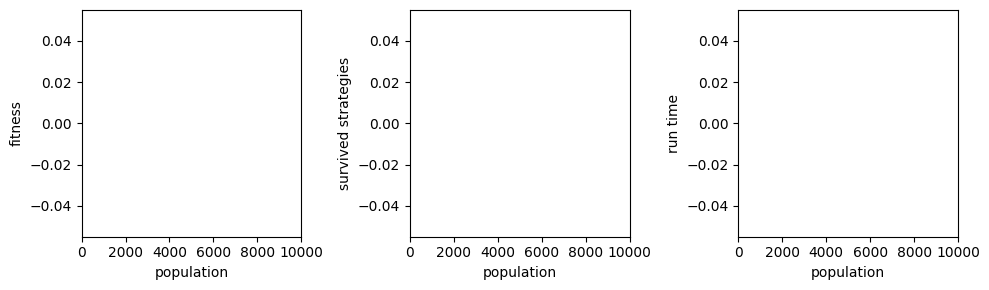

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot()
# plt.xlabel('crossover_probability')
# plt.xlabel('mutation_probability')
# plt.xlabel('elite_size')
# plt.xlabel('generation')
plt.xlabel('population')
# plt.xlim(0, 1)
# plt.xlim(0, 1000)
plt.xlim(0, 10000)
plt.ylabel('fitness')

plt.subplot(1, 3, 2)
plt.plot()
# plt.xlabel('crossover_probability')
# plt.xlabel('mutation_probability')
# plt.xlabel('elite_size')
# plt.xlabel('generation')
plt.xlabel('population')
# plt.xlim(0, 1)
# plt.xlim(0, 1000)
plt.xlim(0, 10000)
plt.ylabel('survived strategies')

plt.subplot(1, 3, 3)
plt.plot()
# plt.xlabel('crossover_probability')
# plt.xlabel('mutation_probability')
# plt.xlabel('elite_size')
# plt.xlabel('generation')
plt.xlabel('population')
plt.xlim(0, 1)
# plt.xlim(0, 1000)
plt.xlim(0, 10000)
plt.ylabel('run time')

plt.tight_layout()

In [16]:
import pandas as pd
import os
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import product

In [2]:
def get_data_dict(data_path, bar_size):

    price_data = {}

    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.sort_values('datetime', ascending=True, inplace=True)

    if bar_size == 1:
        price_data['btc_close'] = df['btc_close'].values
        price_data['btc_open'] = df['btc_open'].values
    else:
        df_cols = list(df.columns)
        df_cols = list(set([col.split('_')[0] for col in df_cols if col!='datetime']))

        df.set_index('datetime', inplace=True)

        instrument_name = df_cols[0]

        final_df = df.resample(f'{bar_size}min').agg({
                f'{instrument_name}_open': 'first',
                f'{instrument_name}_high': 'max',
                f'{instrument_name}_low': 'min',
                f'{instrument_name}_close': 'last',
                f'{instrument_name}_volume': 'sum'
            })
        final_df.reset_index(inplace=True)

        for instrument_name in df_cols[1:]:
            temp_df = df.resample(f'{bar_size}min').agg({
                f'{instrument_name}_open': 'first',
                f'{instrument_name}_high': 'max',
                f'{instrument_name}_low': 'min',
                f'{instrument_name}_close': 'last',
                f'{instrument_name}_volume': 'sum'
            })
            temp_df.reset_index(inplace=True)

            final_df = pd.merge(final_df, temp_df, on='datetime', how='left')

        final_df.reset_index(inplace=True, drop=True)

        price_data['btc_close'] = final_df['btc_close'].values
        price_data['btc_open'] = final_df['btc_open'].values

    return price_data

In [3]:
# cur_dir = os.getcwd()
os.chdir(Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\src'))

from fitness.performance.testing_func import calculate_mean_performance, get_perf_df

data_path = Path(r'/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\Upwork/\AlgoT_ML_Dev/\GrammarEvolution/\PonyGE2/\all_data_1min.csv')

In [4]:
def get_txt_code(
    buy_signal_txt, buy_exit_txt, sell_signal_txt, sell_exit_txt,
    fee=0.015, slippage=0.00005, inv_amount=700000, trade_size=0.5, max_lag=99
):

    text_code = f'''import os
CUR_DIR = os.getcwd()
# os.chdir('src')
#import pandas as pd
import numpy as np
import gc
from fitness.indicators import numba_indicators_nan, signals
from fitness.performance.helper_func import merge_buy_sell_pnl, get_drawdowns, get_pnl, get_lag
from fitness.performance.helper_func import trading_signals_buy, trading_signals_sell, change_exit
# os.chdir(CUR_DIR)
#from numba import njit
COMMISSION = {fee}
SLIPPAGE = {slippage}
AVAILABLE_CAPITAL = {inv_amount}
TRADE_SIZE = {trade_size}
MAX_LAG = {max_lag}
try:
    buy_idxs, buy_exit_idxs = trading_signals_buy(buy_signal={buy_signal_txt}, exit_signal={buy_exit_txt})
except:
    buy_idxs, buy_exit_idxs = [], []
try:
    sell_idxs, sell_exit_idxs = trading_signals_sell(sell_signal={sell_signal_txt}, exit_signal={sell_exit_txt})
except:
    sell_idxs, sell_exit_idxs = [], []
# if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
#     fitness = -9999999
#     avg_drawdown = -9999999
# else:
try:
    buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs = change_exit(buy_idxs, buy_exit_idxs, sell_idxs, sell_exit_idxs)
except:
    pass
if (len(buy_idxs) == 0 or len(buy_exit_idxs) == 0) and (len(sell_idxs) == 0 or len(sell_exit_idxs) == 0):
    fitness = np.nan
    avg_drawdown = np.nan
else:
    buy_idxs = np.array(buy_idxs)
    sell_idxs = np.array(sell_idxs)
    open_prices = price_data['btc_open']
    # pnl_mren_arr, max_dd_mren_arr = get_monkey_test_results(open_prices, buy_idxs, sell_idxs, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE)
    buy_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_idxs)]
    buy_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), buy_exit_idxs)]
    sell_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_idxs)]
    sell_exit_prices = open_prices[np.isin(np.arange(len(open_prices)), sell_exit_idxs)]
    buy_arr = get_pnl(buy_exit_prices, buy_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 1)
    buy_pnl = np.sum(buy_arr)
    sell_arr = get_pnl(sell_exit_prices, sell_prices, COMMISSION, SLIPPAGE, AVAILABLE_CAPITAL, TRADE_SIZE, 0)
    sell_pnl = np.sum(sell_arr)
    all_arr = merge_buy_sell_pnl(buy_idxs, sell_idxs, buy_arr, sell_arr)
    total_pnl = buy_pnl + sell_pnl
    equity_curve_arr = np.cumsum(all_arr)
    drawdowns = get_drawdowns(equity_curve_arr)
    if len(drawdowns[drawdowns!=0]) != 0:
        avg_drawdown = np.sum(drawdowns[drawdowns!=0]) / len(drawdowns[drawdowns!=0])
        fitness = total_pnl / avg_drawdown
    else:
        fitness = np.nan
        avg_drawdown = np.nan
gc.collect()'''
    
    return text_code

In [5]:
windows = [10, 25, 40]

bar_sizes = [
    1, 2, 5, 10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 
    210, 240, 300, 360, 420, 480, 600, 720, 840, 960, 1150, 1440
]

performance_dict = defaultdict(list)

for bar_size in tqdm(bar_sizes):

    for window in windows:

        price_data = get_data_dict(data_path, bar_size=bar_size)

        buy_signal_txt = f"price_data['btc_close'] == signals.moving_max(price_data['btc_close'], window={window})"
        buy_exit_txt = f"price_data['btc_close'] == signals.moving_min(price_data['btc_close'], window={window})"
        sell_signal_txt = f"price_data['btc_close'] == signals.moving_min(price_data['btc_close'], window={window})"
        sell_exit_txt = f"price_data['btc_close'] == signals.moving_max(price_data['btc_close'], window={window})"

        text_code = get_txt_code(buy_signal_txt, buy_exit_txt, sell_signal_txt, sell_exit_txt)

        exec_dict = {'price_data': price_data}
        exec(text_code, exec_dict)

        try:
            metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
            performance_dict['n_trades'].append(metric_dict['n_trades'])
            performance_dict['pnl'].append(metric_dict['overall_pnl'])
            performance_dict['roi'].append(metric_dict['roi'])
            performance_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
            performance_dict['drawdown'].append(metric_dict['max_dd'])
            performance_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
            performance_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
            performance_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
            performance_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
            performance_dict['window'].append(window)
            performance_dict['bar_size'].append(bar_size)
            performance_dict['fitness'].append(exec_dict['fitness'])
            if 'mt_pnl' in metric_dict.keys():
                performance_dict['mt_pnl'].append(metric_dict['mt_pnl'])
                performance_dict['mt_mdd'].append(metric_dict['mt_mdd'])
        except:
            pass

100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


In [6]:
def plot_stat(stat_name, stats_dict, windows, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)

    subplot_idx = 1

    for window in windows:

        plt.subplot(3, 1, subplot_idx)

        pnl_list = [stats_dict[stat_name][i] for i in range(len(stats_dict['window'])) if stats_dict['window'][i]==window]

        bar_list = [stats_dict['bar_size'][i] for i in range(len(stats_dict['window'])) if stats_dict['window'][i]==window]

        plt.bar(np.arange(len(bar_list)), pnl_list)
        plt.xticks(np.arange(len(bar_list)), bar_list, rotation=45)
        plt.title(f"rolling window = {window}")
        plt.xlabel('bar_size')
        plt.ylabel(stat_name)

        subplot_idx += 1

    plt.tight_layout()

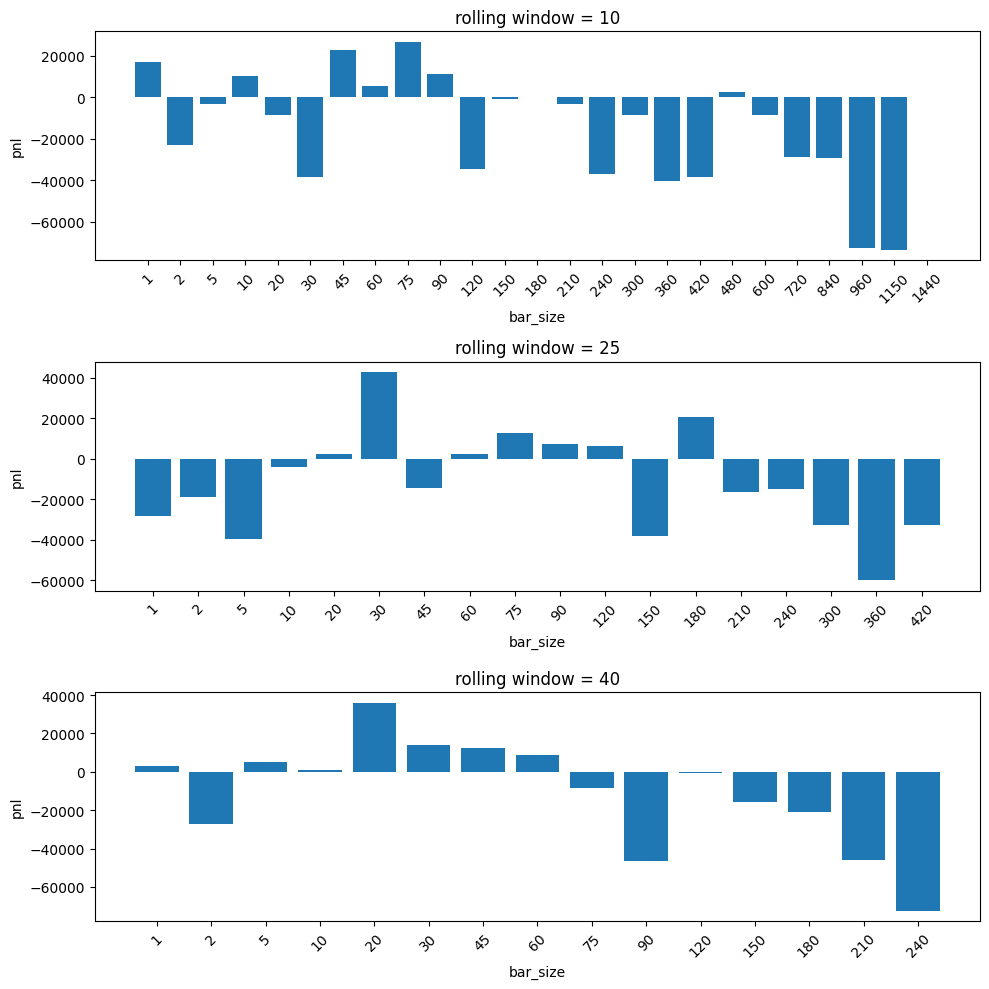

In [7]:
plot_stat(stat_name='pnl', stats_dict=performance_dict, windows=windows)

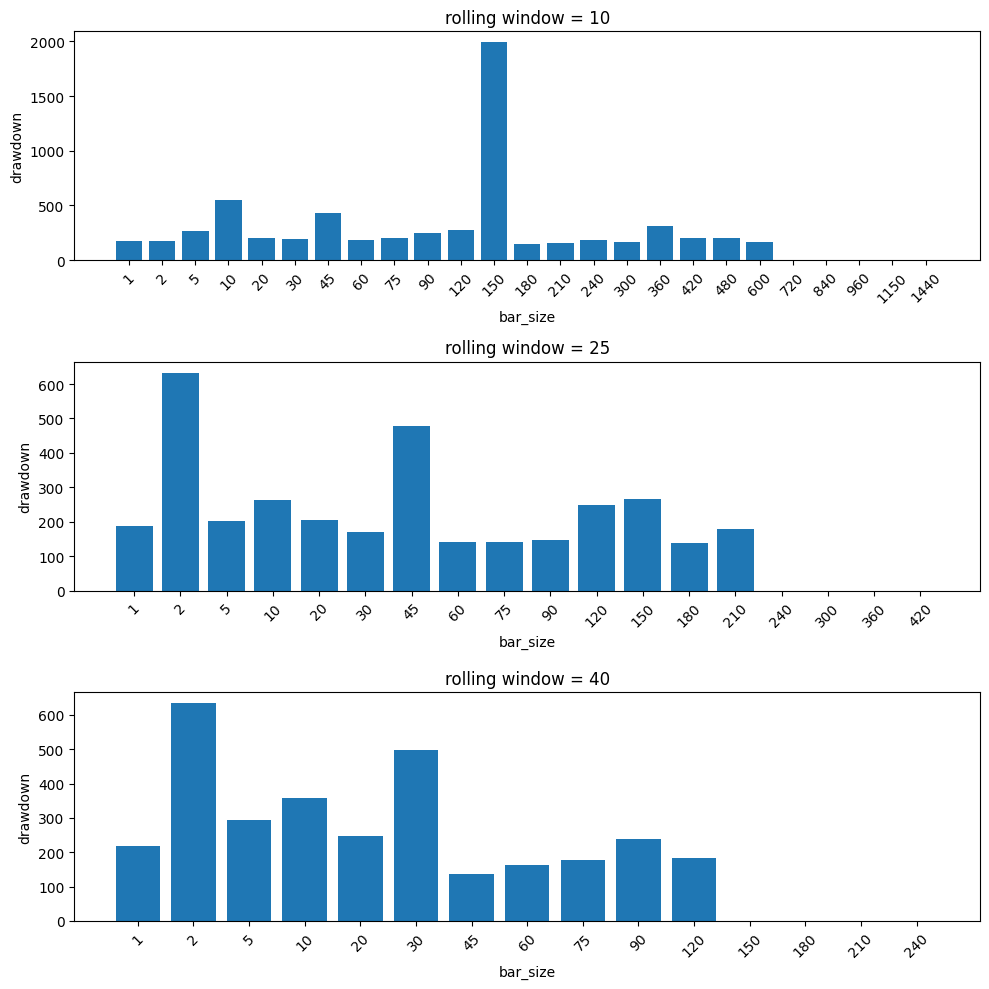

In [8]:
plot_stat(stat_name='drawdown', stats_dict=performance_dict, windows=windows)

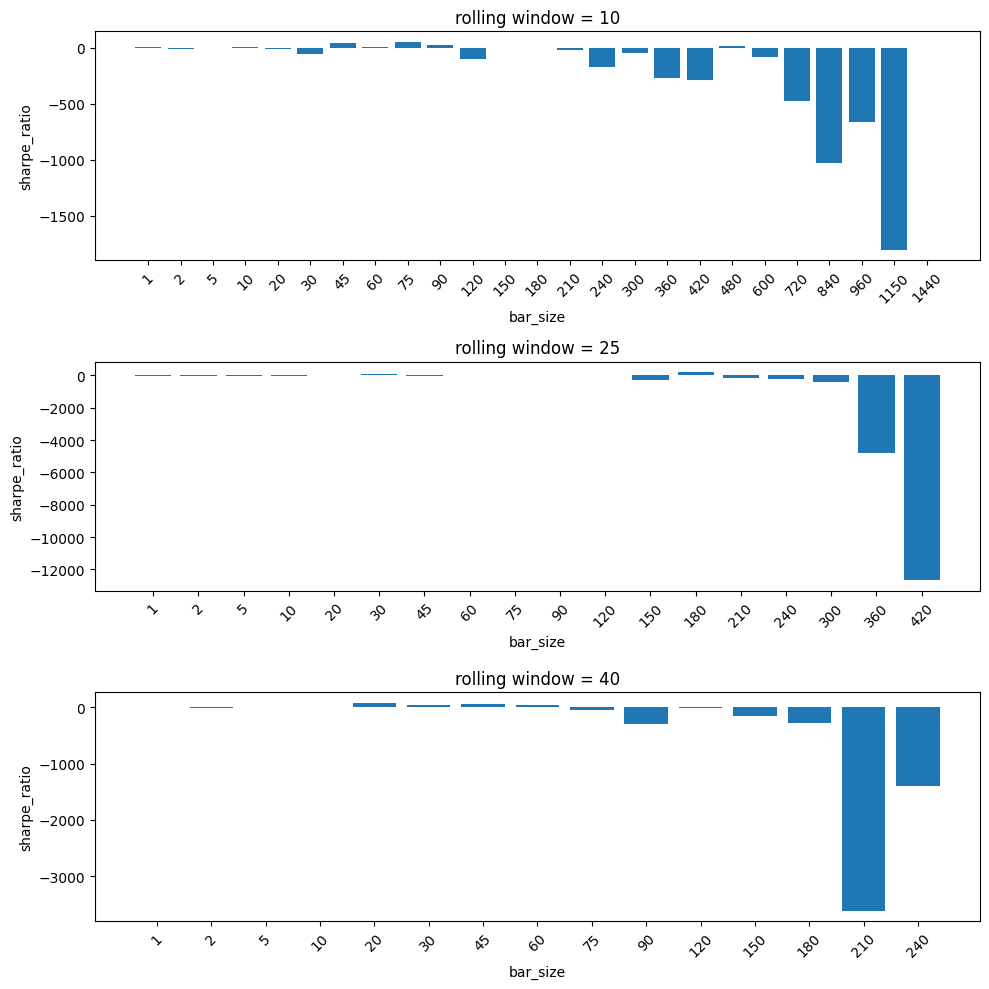

In [9]:
plot_stat(stat_name='sharpe_ratio', stats_dict=performance_dict, windows=windows)

In [66]:
performance_dict.keys()

dict_keys(['n_trades', 'pnl', 'roi', 'avg_drawdown', 'drawdown', 'drawdown_dur', 'pnl_avgd_ratio', 'sharpe_ratio', 'sortino_ratio', 'window', 'bar_size', 'fitness'])

In [10]:
windows = [10, 25, 40]

bar_sizes = [
    1, 2, 5, 10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 
    210, 240, 300, 360, 420, 480, 600, 720, 840, 960, 1150, 1440
]

performance_dict = defaultdict(list)

for bar_size in tqdm(bar_sizes):

    for window in windows:

        price_data = get_data_dict(data_path, bar_size=bar_size)

        buy_signal_txt = f"price_data['btc_close'] == signals.moving_min(price_data['btc_close'], window={window})"
        buy_exit_txt = f"price_data['btc_close'] == signals.moving_max(price_data['btc_close'], window={window})"
        sell_signal_txt = f"price_data['btc_close'] == signals.moving_max(price_data['btc_close'], window={window})"
        sell_exit_txt = f"price_data['btc_close'] == signals.moving_min(price_data['btc_close'], window={window})"
        
        text_code = get_txt_code(buy_signal_txt, buy_exit_txt, sell_signal_txt, sell_exit_txt)

        exec_dict = {'price_data': price_data}
        exec(text_code, exec_dict)

        try:
            metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
            performance_dict['n_trades'].append(metric_dict['n_trades'])
            performance_dict['pnl'].append(metric_dict['overall_pnl'])
            performance_dict['roi'].append(metric_dict['roi'])
            performance_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
            performance_dict['drawdown'].append(metric_dict['max_dd'])
            performance_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
            performance_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
            performance_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
            performance_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
            performance_dict['window'].append(window)
            performance_dict['bar_size'].append(bar_size)
            performance_dict['fitness'].append(exec_dict['fitness'])
            if 'mt_pnl' in metric_dict.keys():
                performance_dict['mt_pnl'].append(metric_dict['mt_pnl'])
                performance_dict['mt_mdd'].append(metric_dict['mt_mdd'])
        except:
            pass

100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


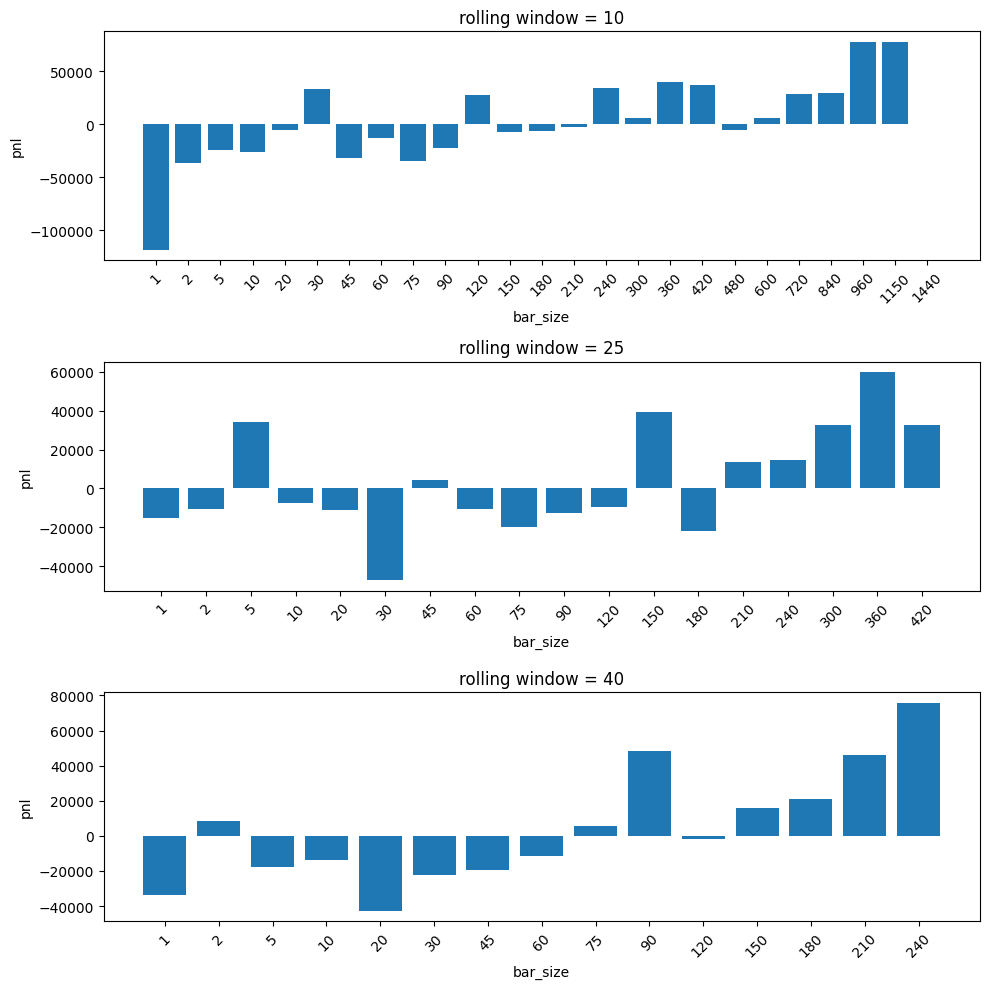

In [11]:
plot_stat(stat_name='pnl', stats_dict=performance_dict, windows=windows)

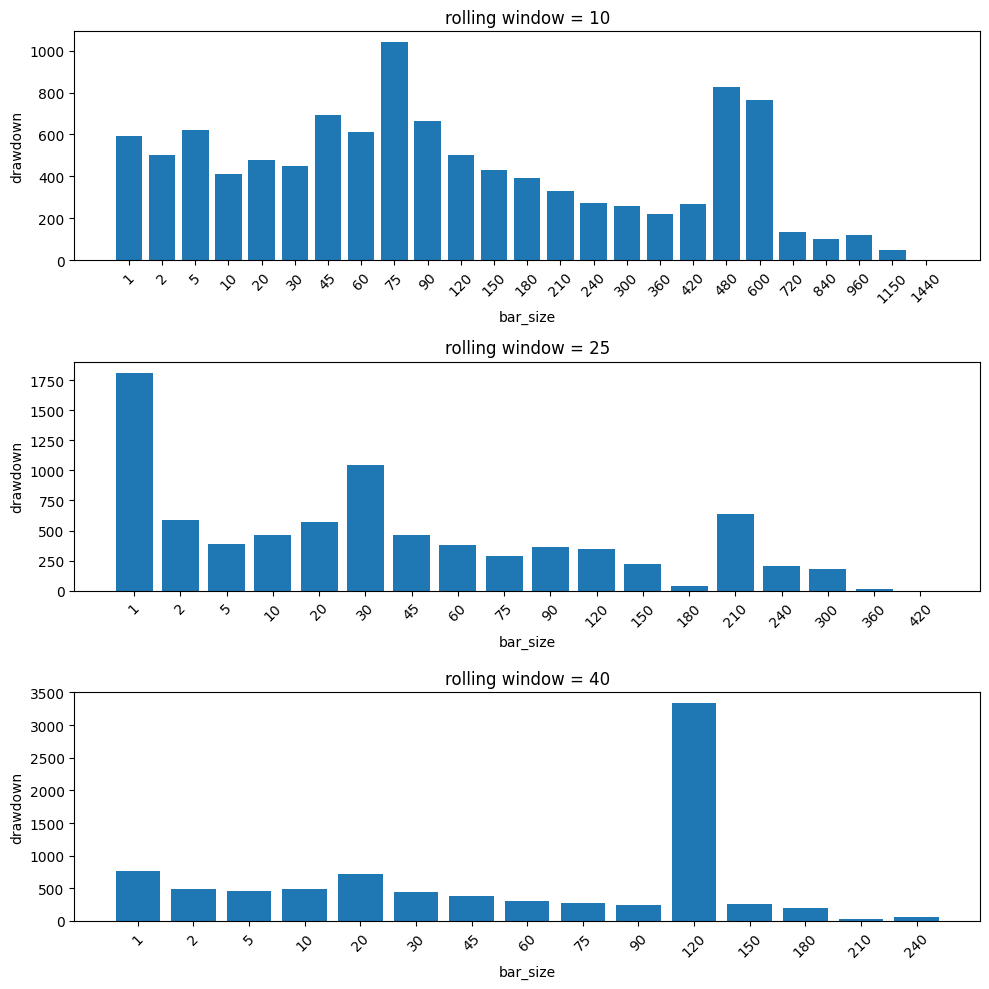

In [12]:
plot_stat(stat_name='drawdown', stats_dict=performance_dict, windows=windows)

# Mean reversion strategies

## Strategy #1 – Simple Short Term RSI

In [37]:
def get_exit_point(signal_condition, n_bars=7):
    temp_condition = signal_condition.copy()
    idx = np.where(temp_condition==True)[0]
    temp_condition[idx] = False
    idx = idx + n_bars + 1
    temp_condition[idx] = True
    return temp_condition

# buy_condition = (numba_indicators_nan.relative_strength_index(prices=price_data['btc_close'], window=2) < 5)
# print(buy_condition)
# print(get_exit_point(signal_condition=buy_condition))

In [41]:
InputVar2_list = np.arange(5, 21, 5)
InputVar3_list = np.arange(25, 41, 5)
inputVar4_list = [0, 1]
inputVar5_list = [0, 1]

n_exit_bars = 7

parameters_list = list(product(InputVar2_list, InputVar3_list, inputVar4_list, inputVar5_list))

# if InputVar5=1 then exit 7 bars after entry

# windows = [10, 25, 40]

# bar_sizes = [
#     1, 2, 5, 10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 
#     210, 240, 300, 360, 420, 480, 600, 720, 840, 960, 1150, 1440
# ]

performance_dict = defaultdict(list)

for InputVar2, InputVar3, InputVar4, InputVar5 in tqdm(parameters_list):

    price_data = get_data_dict(data_path, bar_size=bar_size)

    buy_signal_txt = f"numba_indicators_nan.relative_strength_index(prices=price_data['btc_close'], window=2) < {InputVar2}"
    sell_signal_txt = f"numba_indicators_nan.relative_strength_index(prices=price_data['btc_close'], window=2) > {100 - InputVar2}"

    if InputVar4 == 1:
        buy_exit_txt = f"numba_indicators_nan.relative_strength_index(prices=price_data['btc_close'], window=2) > {InputVar3}"
        sell_exit_txt = f"numba_indicators_nan.relative_strength_index(prices=price_data['btc_close'], window=2) < {100 - InputVar3}"
    else:
        buy_exit_txt = sell_signal_txt
        sell_exit_txt = buy_signal_txt
    
    if InputVar5 == 1:
        buy_exit_txt = f"get_exit_point(signal_condition=({buy_signal_txt}), n_bars={n_exit_bars})"
        sell_exit_txt = f"get_exit_point(signal_condition=({sell_signal_txt}), n_bars={n_exit_bars})"
    
    text_code = get_txt_code(buy_signal_txt, buy_exit_txt, sell_signal_txt, sell_exit_txt)

    exec_dict = {'price_data': price_data}
    exec(text_code, exec_dict)

    try:
        metric_dict = calculate_mean_performance(exec_dict, monkey_test=False)
        performance_dict['n_trades'].append(metric_dict['n_trades'])
        performance_dict['pnl'].append(metric_dict['overall_pnl'])
        performance_dict['roi'].append(metric_dict['roi'])
        performance_dict['avg_drawdown'].append(metric_dict['avg_drawdown'])
        performance_dict['drawdown'].append(metric_dict['max_dd'])
        performance_dict['drawdown_dur'].append(metric_dict['drawdown_dur'])
        performance_dict['pnl_avgd_ratio'].append(metric_dict['pnl_avgd_ratio'])
        performance_dict['sharpe_ratio'].append(metric_dict['sharpe_ratio'])
        performance_dict['sortino_ratio'].append(metric_dict['sortino_ratio'])
        performance_dict['InputVar2'].append(InputVar2)
        performance_dict['InputVar3'].append(InputVar3)
        performance_dict['InputVar4'].append(InputVar4)
        performance_dict['InputVar5'].append(InputVar5)
        performance_dict['fitness'].append(exec_dict['fitness'])
        if 'mt_pnl' in metric_dict.keys():
            performance_dict['mt_pnl'].append(metric_dict['mt_pnl'])
            performance_dict['mt_mdd'].append(metric_dict['mt_mdd'])
    except:
        pass

100%|██████████| 64/64 [01:11<00:00,  1.11s/it]


In [72]:
def plot_stat2(stat_name, stats_dict, InputVar2_list, InputVar3_list, InputVar4=0, InputVar5=0, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)

    subplot_idx = 1

    for InputVar2 in InputVar2_list:

        plt.subplot(2, 4, subplot_idx)

        pnl_list = [
            stats_dict[stat_name][i] for i in range(len(stats_dict['InputVar2'])) 
            if (stats_dict['InputVar4'][i]==InputVar4 and stats_dict['InputVar5'][i]==InputVar5 and stats_dict['InputVar2'][i]==InputVar2)
        ]

        var_list = [
            stats_dict['InputVar3'][i] for i in range(len(stats_dict['InputVar2'])) 
            if (stats_dict['InputVar4'][i]==InputVar4 and stats_dict['InputVar5'][i]==InputVar5 and stats_dict['InputVar2'][i]==InputVar2)
        ]

        plt.bar(np.arange(len(var_list)), pnl_list)
        plt.xticks(np.arange(len(var_list)), var_list, rotation=45)
        plt.title(f"InputVar2 = {InputVar2}")
        plt.xlabel('InputVar3')
        plt.ylabel(stat_name)

        subplot_idx += 1

    for InputVar3 in InputVar3_list:

        plt.subplot(2, 4, subplot_idx)

        pnl_list = [
            stats_dict[stat_name][i] for i in range(len(stats_dict['InputVar3'])) 
            if (stats_dict['InputVar4'][i]==InputVar4 and stats_dict['InputVar5'][i]==InputVar5 and stats_dict['InputVar3'][i]==InputVar3)
        ]

        var_list = [
            stats_dict['InputVar2'][i] for i in range(len(stats_dict['InputVar3'])) 
            if (stats_dict['InputVar4'][i]==InputVar4 and stats_dict['InputVar5'][i]==InputVar5 and stats_dict['InputVar3'][i]==InputVar3)
        ]

        plt.bar(np.arange(len(var_list)), pnl_list)
        plt.xticks(np.arange(len(var_list)), var_list, rotation=45)
        plt.title(f"InputVar3 = {InputVar3}")
        plt.xlabel('InputVar2')
        plt.ylabel(stat_name)

        subplot_idx += 1

    plt.suptitle(f'InputVar4 = {InputVar4}, InputVar5 = {InputVar5}')

    plt.tight_layout()

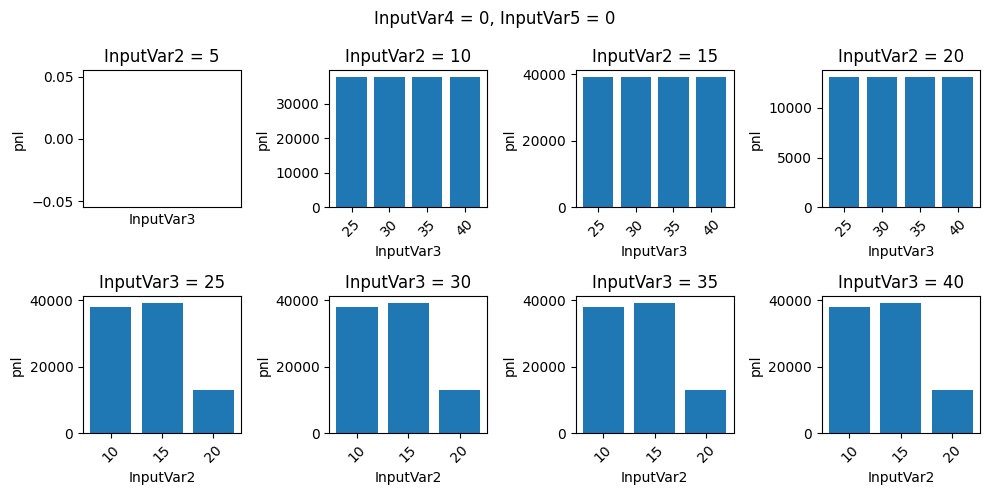

In [73]:
plot_stat2(
    stat_name='pnl', stats_dict=performance_dict, InputVar2_list=InputVar2_list, 
    InputVar3_list=InputVar3_list, InputVar4=0, InputVar5=0, figsize=(10, 5)
)

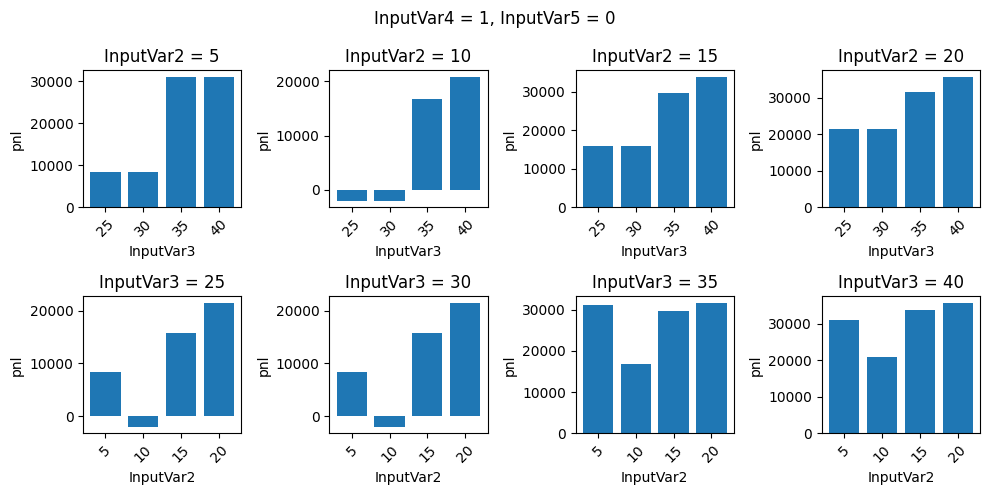

In [74]:
plot_stat2(
    stat_name='pnl', stats_dict=performance_dict, InputVar2_list=InputVar2_list, 
    InputVar3_list=InputVar3_list, InputVar4=1, InputVar5=0, figsize=(10, 5)
)

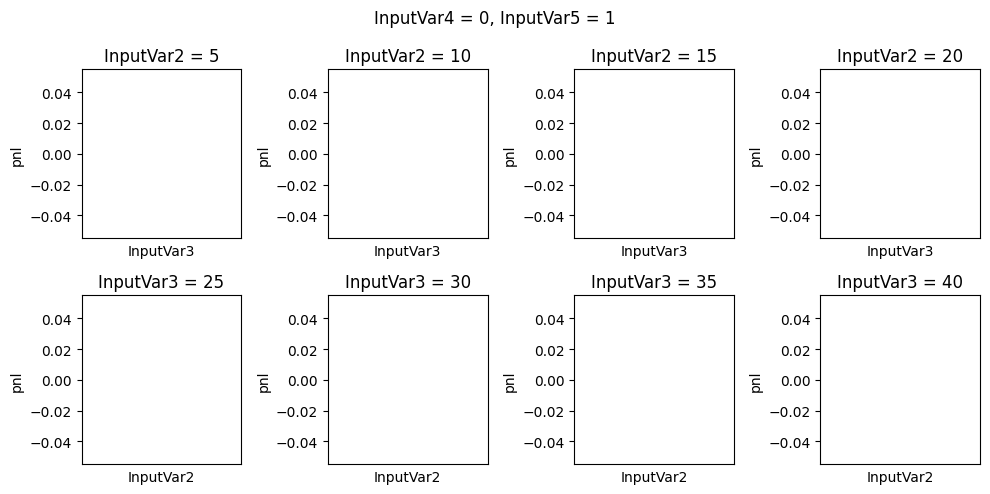

In [75]:
plot_stat2(
    stat_name='pnl', stats_dict=performance_dict, InputVar2_list=InputVar2_list, 
    InputVar3_list=InputVar3_list, InputVar4=0, InputVar5=1, figsize=(10, 5)
)

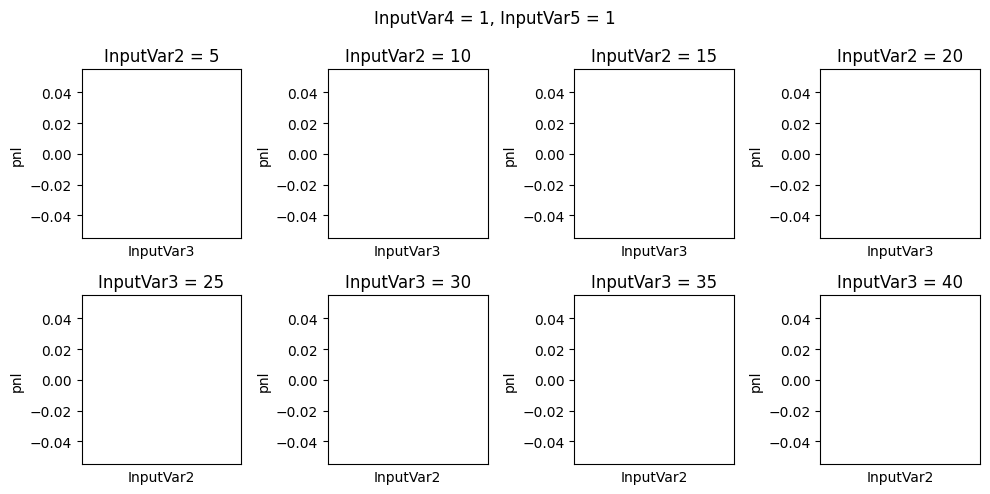

In [76]:
plot_stat2(
    stat_name='pnl', stats_dict=performance_dict, InputVar2_list=InputVar2_list, 
    InputVar3_list=InputVar3_list, InputVar4=1, InputVar5=1, figsize=(10, 5)
)